## all-atom diffusion map

### setup

In [1]:


import os
import matplotlib as mpl
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import math
import time
import pickle
from copy import deepcopy

import numpy as np

import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split
from sklearn import manifold

from scipy.linalg import orthogonal_procrustes
from scipy.linalg import eigh

from collections import OrderedDict

import mdtraj as md

In [2]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2'''

In [3]:
# fix random seed for reproducibility
randstate = 200184
np.random.seed(randstate)

In [4]:
5==5

True

### loading simulation trajectory

534743
(534743, 3)
(534743,)
534742


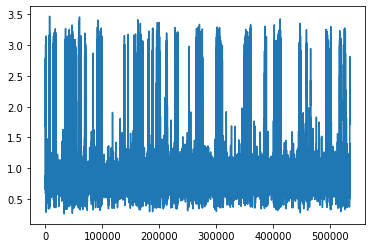

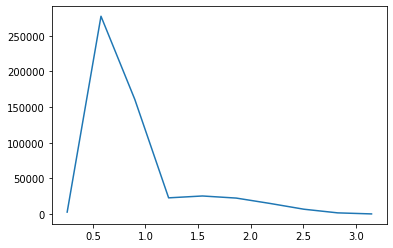

40000 427794
40008
40008 indx 40008


KeyboardInterrupt: 

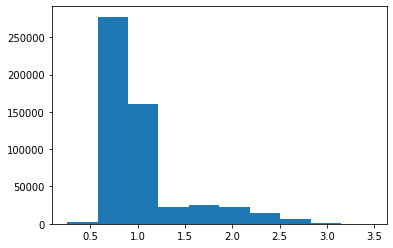

In [4]:
bin_sizes = [1,5,10,25,50]
Dvec = [40000,20000,10000,1000] 

for Dv in Dvec:
    for b in bin_sizes:
        dim = 11
        trj_file = '../0A_aa_h2t/trj_%fns.xtc' %(b*0.2)
        pdb_file = '../0A_aa_h2t/trj_init%fns.pdb' %(b*0.2)

        # loading
        traj = md.load(trj_file, top=pdb_file)

        print(len(traj))

        npzfile = np.load('../0A_aa_h2t/princMom_%fns.npz' %(b*0.2)) 
        sorted(npzfile.files)
        princMom = npzfile['princMom']
        Rg = npzfile['Rg']

        print(princMom.shape)
        print(Rg.shape)
        npzfile = np.load('../0A_aa_h2t/h2t_%fns.npz' %(b*0.2)) 
        sorted(npzfile.files)
        h2t = npzfile['h2t_train']

        print(len(h2t))
        plt.plot(h2t)
        plt.show()
        no = list(np.histogram(h2t,bins=10)[0])
        val = list(np.histogram(h2t,bins=10)[1][0:10])
        plt.plot(val,no)
        plt.show()
        plt.hist(h2t)

        indx = []
        j = 0
        # Train in 40k data points
        stopframe = Dv
        #Chose over first 450000
        totframe = int(round(len(h2t)*0.8))
        # number of pieces
        nohist = 10
        #train 10 percent on each ile
        ratio = 1/nohist
        print(stopframe,totframe)

        #find histogram values
        no = list(np.histogram(h2t[0:totframe],bins=nohist)[0])
        val = list(np.histogram(h2t[0:totframe],bins=nohist)[1][0:nohist])
        val.insert(0,0)


        #iterate over the number of histogram divisions
        for ile in range(nohist):
            #print(ile)
            # iterate over all frames
            for i in range(totframe):
                #iterate over deciles
                #print(stopframe*ratio*(ile+1))
                if j < stopframe*ratio*(ile+1):
                    # select that it is in the correct decile
                    if h2t[i] < val[ile+1] and h2t[i] > val[ile]:
                         for d in range(dim):
                                if (i+d) not in indx:
                                    #print(i-d)
                                    indx.append(i+d)
                                    j += 1
                                    #print(i-d)
                                    #print(indx[])

                    #print(ile+1, j)
                elif j >= stopframe:
                    #print(ile,i,j)
                    break
        print(j)
        traj_ss = deepcopy(traj[indx])
        princMom_ss = princMom[indx]
        Rg_ss = Rg[indx]
        h2t_ss = h2t[indx]

        print(len(h2t_ss), 'indx', len(indx))
        traj_ss_flip = deepcopy(traj_ss)
        for i in range(traj_ss_flip.n_frames):
            traj_ss_flip.xyz[i] = np.fliplr(np.flipud(traj_ss_flip.xyz[i]))
        traj_ss_mir = deepcopy(traj_ss)
        for i in range(traj_ss_mir.n_frames):
            xyz = deepcopy(traj_ss_mir.xyz[i])
            xyz[:,0] = -xyz[:,0]
            traj_ss_mir.xyz[i] = xyz

        N = traj_ss.n_frames #.n_frames
        P = np.zeros((N,N),dtype=float)
        for i in range(N-1):
            RMSD_i_normal = md.rmsd(traj_ss[i+1:],traj_ss[i],frame=0)
            #RMSD_i_flip = md.rmsd(traj_ss_flip[i+1:],traj_ss[i],frame=0)
            RMSD_i_mir = md.rmsd(traj_ss_mir[i+1:],traj_ss[i],frame=0)
            #RMSD_i = np.minimum(np.minimum(RMSD_i_normal,RMSD_i_flip),RMSD_i_mir)
            RMSD_i = np.minimum(RMSD_i_normal,RMSD_i_mir)
            P[i,i+1:] = RMSD_i
        P = P + P.T
        print(P.shape)
        outfile='P_%dk_%fns.npz' %(Dv,b*0.2)
        np.savez(outfile, P=P)

        # selecting
        eps = np.exp(-3)

        #outfile='P.npz'
        #npzfile = np.load(outfile)
        #sorted(npzfile.files)
       # P = npzfile['P']

        P = np.exp(-P**2/(2*eps))
        D = np.sum(P,axis=1)
        P = np.matmul(np.matmul(np.diag(D**(-0.5)),P),np.diag(D**(-0.5))) # constructing Ms as symmetric matrix for diagonalization

        #assert np.allclose(P, P.T)

        nEvals=20
        lamb, psi = eigh(P,eigvals=(P.shape[0]-nEvals,P.shape[0]-1)) # scipy eigh to specify only computation of leading evals
        psi = np.matmul(np.diag(D**(-0.5)),psi) # converting evecs of Ms to evecs of M; M and Ms share evals

        idx_sort = np.flip(np.argsort(lamb))

        lamb = lamb[idx_sort]
        psi = psi[:,idx_sort]

        # plotting eval spectrum
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.bar(np.arange(1,len(lamb)), lamb[1:])
        ax.set_xlabel('eval idx')
        ax.set_ylabel('eval')
        plt.xticks(np.arange(1, len(lamb), step=1),fontsize=10)
        plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],fontsize=10)

        if showPlots:
            plt.draw()
            plt.show()
        fig.savefig('evals_%dk_%fns.png' %(Dv,b*0.2), dpi=300)
        plt.close()

        # plotting embedding

        plot_stride = 100

        #colorMap = h2t_ss[::plot_stride].reshape(-1)
        #colorMap = Rg_ss[::plot_stride].reshape(-1)
        #colorMap = princMom_ss[::plot_stride,2]

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(psi[::plot_stride,1], psi[::plot_stride,2])#, c=colorMap)
        ax.set_xlabel('psi_2')
        ax.set_ylabel('psi_3')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.xlim([np.min(psi[:,1])*1.1,np.max(psi[:,1])*1.1])
        plt.ylim([np.min(psi[:,2])*1.1,np.max(psi[:,2])*1.1])
        if showPlots:
            plt.draw()
            plt.show()
        fig.savefig('evecs_%dk_%fns.png' %(Dv,b*0.2), dpi=300, fontsize=15)
        plt.close()

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(psi[::plot_stride,1], psi[::plot_stride,2], psi[::plot_stride,3])#, c=colorMap)
        ax.set_xlabel('psi_2')
        ax.set_ylabel('psi_3')
        ax.set_zlabel('psi_4')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        if showPlots:
            plt.draw()
            plt.show()
        fig.savefig('evecs_234_%dk_%fns.png' %(Dv,b*0.2), dpi=300, fontsize=15)
        plt.close()

        # Nystrom extension applied to all frames in data set

        z = []

        start = time.time()

        print('Commencing Nystrom extension...')
        for i in range(traj.n_frames):
            RMSD_i_normal = md.rmsd(traj_ss,traj[i],frame=0)
            #RMSD_i_flip = md.rmsd(traj_ss_flip,traj[i],frame=0)
            RMSD_i_mir = md.rmsd(traj_ss_mir,traj[i],frame=0)
            RMSD_i = np.minimum(RMSD_i_normal,RMSD_i_mir)

            RMSD_i = np.exp(-RMSD_i**2/(2*eps))

            RMSD_i /= np.sum(RMSD_i)

            psi_Nystrom = np.divide( np.matmul(RMSD_i,psi), lamb)

            z.append(psi_Nystrom)

            if np.mod(i+1,5000) == 0:
                print('\tNystromed %d of %d frames...' % (i+1,traj.n_frames))

        z = np.array(z)
        z = z.reshape(z.shape[0],-1)

        print('DONE!')
        print('')

        end = time.time()
        print("Elapsed time %.2f (s)" % (end - start))

        np.savez('data_%dk_%fns.npz' %(Dv,b*0.2), z=z)
        print('Finished run %dk %fns' %(Dv, b*0.2))

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from copy import deepcopy

In [24]:
Zx = np.array([-20e-5,-10e-5,0,10e-5,20e-5])
Zy =np.array([-1e-4,-0.5e-4,0,0.5e-4,1e-4])
Zxlbl=['-20','-10','0','10','20']
Zylbl=['10','5','0','-5','-10']

#Zx = np.array([-20e-5,-10e-5,0,10e-5,20e-5])
#Zy =np.multiply(np.array([-2.5e-4,-1e-4,-0.5e-4,0,0.5e-4,1e-4]),-1)
#Zxlbl=['-20','-10','0','10','20']
#Zylbl=['-10','-5','0','5','10','15']

363 830


/home/maxtopel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in log


-8.702907814215715
[-1.7e-04 -6.2e-05  4.2e-05  1.5e-04  2.5e-04]
[-8.4e-05 -3.9e-05  6.8e-06  5.2e-05  9.8e-05]
232 647
-9.207216397616309
[-1.7e-04 -8.5e-05 -3.6e-06  7.7e-05  1.6e-04]
[-6.0e-05 -3.1e-05 -2.1e-06  2.7e-05  5.6e-05]
207 645
-9.416202206749132
[-1.7e-04 -9.1e-05 -1.1e-05  7.0e-05  1.5e-04]
[-5.3e-05 -2.7e-05 -7.1e-07  2.5e-05  5.1e-05]
201 561
-9.117156832032103
[-1.7e-04 -9.7e-05 -2.7e-05  4.3e-05  1.1e-04]
[-5.7e-05 -3.2e-05 -6.8e-06  1.8e-05  4.4e-05]
201 486
-8.952948474460312
[-1.4e-04 -8.2e-05 -2.1e-05  3.9e-05  1.0e-04]
[-5.4e-05 -2.8e-05 -3.2e-06  2.2e-05  4.7e-05]


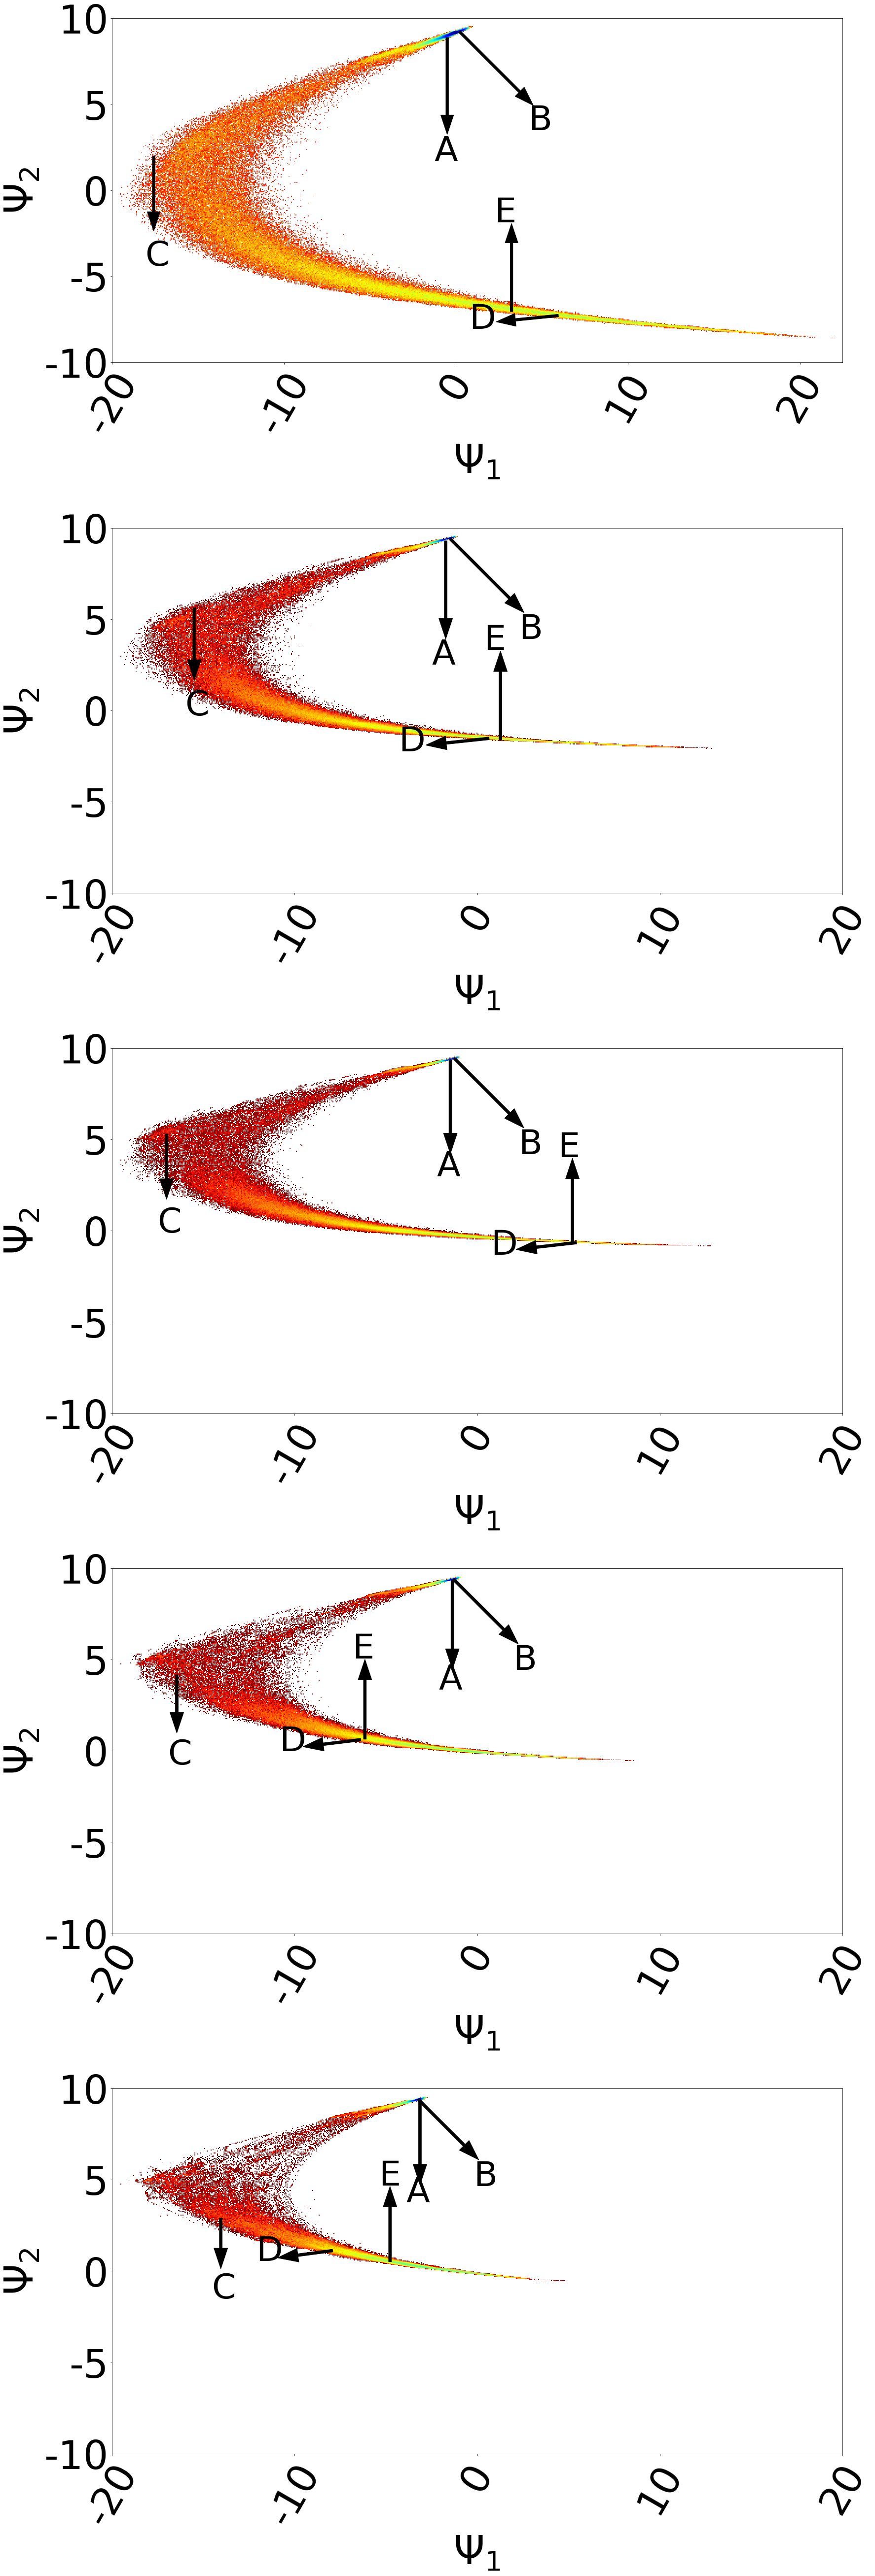

[-2.25201072386059, -2.7148760330578514, -3.0184331797235022, -2.706161137440758, -2.3507109004739335]


In [25]:

#ONE PLOT STYLE

limit=[]
#xlbl = [[],[],[],[],[]]
#ylbl = [[],[],[],[],[]]
bin_sizes = [1,5,10,25,50]
Dvec = [40000] #,20000,10000,1000 

#bin_sizes = [1]
#Dvec = [40000] 
#xmin=10000
#ymin = 10000
#xmax = -10000
#ymax = -10000
icount = 0

fig, ax = plt.subplots(len(bin_sizes),1,figsize=(25, 15*len(bin_sizes)),gridspec_kw={'height_ratios': [1,1,1,1,1]})

#specify individual sizes for subplots
#fig, ax = plt.subplots(len(bin_sizes), gridspec_kw={'height_ratios': [1,1,1,1,1]})
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

mpl.rc('xtick', labelsize=80)
mpl.rc('ytick', labelsize=80)

for Dv in Dvec:
    for binsz in bin_sizes:
        flag = 0
        npzfile = np.load('data_%dk_%fns.npz' %(Dv,binsz*0.2))
        z = npzfile['z']
        zp = z[:,[1,2]]
        #zp[:,0] = -zp[:,0]
        if binsz==1:
            zp[:,0] = -zp[:,0]
           # zp[:,1] = -zp[:,1]
        
        
        one_max = max(zp[:,0])
        one_min = min(zp[:,0]) 
        two_max = max(zp[:,1])
        two_min = min(zp[:,1])
        
        
        
        
        # move the range so that all numbers are positive
        if one_min < 0: 
            zp[:,0] += abs(one_min)
        elif one_min > 0:
            zp[:,0] -= abs(one_min)
            
        if two_min < 0: 
            zp[:,1] += abs(two_min)
        elif two_min > 0:
            zp[:,1] -= abs(two_min)
        print(int((one_max-one_min)/5e-7),int((two_max-two_min)/5e-7))
            
        # make all elements of zp positive numbers that can correspond to cells
        zp /= 5e-7
        # an assumption of initial conditions
        k_b = 1.38064852e-23
        T = 300
        b = k_b*T

        d_x = int((one_max-one_min)/5e-7)+10
        d_y = int((two_max-two_min)/5e-7)+10
        
        Xz = np.subtract(np.subtract(np.divide(Zx,5e-7),10),Zx[0]/5e-7)
        Yz = np.subtract(np.subtract(np.divide(Zy,5e-7),10),Zy[0]/5e-7)
        
        xp = np.linspace(one_min,one_max,10)
        yp = np.linspace(two_min,two_max,10)

        for i in range(len(xp)):
            xp[i] = round(xp[i],4)
            yp[i] = round(yp[i],4)

        x = range(d_x)
        y= range(d_y)
        xx = range(0,d_x,int(d_x/10))
        yy= range(0,d_y,int(d_y/10))
        # Let's make a free energy landscape

        #Make a lattice in the region in numpy
        lattice = np.zeros([d_x,d_y])
        #lattice = np.empty([d_x,d_y])
        #psi_2 from -0.0001 to 0.0007
        for i in range(len(zp)):
            #resolution in dimensions 1, 2 is 1e-9
            l = int(np.floor(zp[i,0]))
            m = int(np.floor(zp[i,1]))
            #try:
            lattice[l,m] += 1
            #except:
             #   flag +=1
              #  pass

        # normalize probabilities 
        lattice /= len(z)
        # normalize for grid sizing
        lattice *= d_x*d_y
        
        lattice[:,1] = -lattice[:,1]
        
        #deep copy lattice for processing 
        F = deepcopy(lattice)
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                #if F[l,m] !=np.NaN:
                    F[l,m] = -np.log(F[l,m]) #+ 7.135528098680009

        Fp = list(F)
        maxi =0
        for i in range(len(Fp)):
            Fpp = min(Fp[i])
            if maxi > Fpp:
                maxi = Fpp
        print(maxi)
        
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                    F[l,m] -= maxi
                elif F[l,m] ==0:
                    F[l,m] = np.NaN

        #Heatmap 1

        
        ax[icount].imshow(F, cmap='jet', interpolation='nearest', vmin=0, vmax=10.5)
        ax[icount].set_xlabel('$\Psi_1$', fontsize=80)
        ax[icount].set_ylabel('$\Psi_2$', fontsize=80)

        
        yl = ax[icount].get_ylim()
        xl = ax[icount].get_xlim()
        limit.append((xl[1]-xl[0])/(yl[1]-yl[0]))
        
        yrng = np.linspace(one_min,one_max,5)
        xrng =  np.linspace(two_min,two_max,5)
       
        #xlrng = np.linspace(float(xl[0]),float(xl[1]),5)
        xlrng = np.linspace(float(yl[0]*3.1),float(yl[1])*3.1,5)
        ylrng = np.linspace(float(yl[0]),float(yl[1]),5) #
        
    
         
        
        for i in range(len(xrng)):
           # xrng[i] = np.float(format(np.float(np.format_float_positional(xrng[i],precision=7,trim='k')), '.7f'))
            xrng[i] = np.format_float_scientific(xrng[i],precision=1,trim='-')#format(np.float(),'.7e'))

        for i in range(len(yrng)):
            yrng[i] = np.format_float_scientific(yrng[i],precision=1,trim='-')


        print(xrng)
        print(yrng)
        
        ##########################################################
        ax[icount].set_xticks(Xz)
        ax[icount].set_yticks(Yz)
        ax[icount].set_xticklabels(Zxlbl,rotation=60)
        ax[icount].set_yticklabels(Zylbl)
        
        
        #ax[icount].set_xticks(xlrng)
        #ax[icount].set_yticks(ylrng)
        #ax[icount].set_xticklabels(xlbl[icount],rotation=60)
        #ax[icount].set_yticklabels(ylbl[icount])
        #############################################################
        
        ax[icount].arrow(zp[17230,1], zp[17230,0], -50+3*icount,5, head_width = 15, width = 3,color='black')
        ax[icount].arrow(zp[27211,1], zp[27211,0], 0, 90-5*icount, head_width = 15, width = 3,color='black')
        ax[icount].arrow(zp[40100,1], zp[40100,0], 0, 65-8*icount, head_width = 15, width = 3,color='black')
        ax[icount].arrow(zp[58718,1], zp[58718,0], 0, -80+5*icount, head_width = 15, width = 3,color='black')
        ax[icount].arrow(zp[83065,1], zp[83065,0], 70-5*icount, 70-5*icount, head_width = 15, width = 3,color='black')
        
        ax[icount].text(zp[17230,1]-80*1.3+5*icount, zp[17230,0]+15-icount*1, 'D',fontsize=70)#, horizontalalignment='left', verticalalignment='center')#, transform=ax1.transAxes)
        ax[icount].text(zp[27211,1] -15, zp[27211,0]+110*1.3-8*icount, 'A',fontsize=70)
        ax[icount].text(zp[40100,1]+ -10 , zp[40100,0]+85*1.5-10*icount, 'C',fontsize=70)
        ax[icount].text(zp[58718,1]+ -20+icount*2 , zp[58718,0]-80*1.3+5*icount, 'E',fontsize=70)
        ax[icount].text(zp[83065,1]+ 80 -5*icount, zp[83065,0]+80*1.3-5*icount+10, 'B',fontsize=70)

        icount +=1

    
        #plt.gca().invert_yaxis()
    fig.tight_layout(rect=[0,0,0.99,0.99])    
    plt.show()
     
    fig.savefig('Chignolin_smFES_%dk.png' %(Dv), dpi=300)
    print(limit)
        #print(flag)
        #fig.savefig('Chig_map_gen_%dk_%fns.png' %(Dv,b*0.2), dpi=300)

In [40]:
Yz

array([-10., 190., 390., 590., 790.])

In [11]:
xlbl = [[],[],[],[],[]]
ylbl = [[],[],[],[],[]]
xlbl[0]=[-1.7,-0.6,0.4,1.5,2.5]    #e4/e5
ylbl[0]=[-8.4, -3.9, 0.7,  5.2,  9.8]

xlbl[1]=[-1.7, -0.9, -0.1,  0.8,  1.6]
ylbl[1]=[-6.0, -3.1, -0.2,  2.7,  5.6]

xlbl[2]=[-1.7, -0.9, -0.1,  0.7,  1.5]
ylbl[2]=[-5.3, -2.7, -0.1,  2.5,  5.1]

xlbl[3]=[-1.7, -1.0, -0.3,  0.4,  1.1]
ylbl[3]=[-5.7, -3.2, -0.7,  1.8,  4.4]

xlbl[4]=[-1.4, -0.8, -0.2,  0.4,  1.0]
ylbl[4]=[-5.4, -2.8, -0.3, 2.2,  4.7]


363 830
-8.702907814215715


NameError: name 'xlbl' is not defined

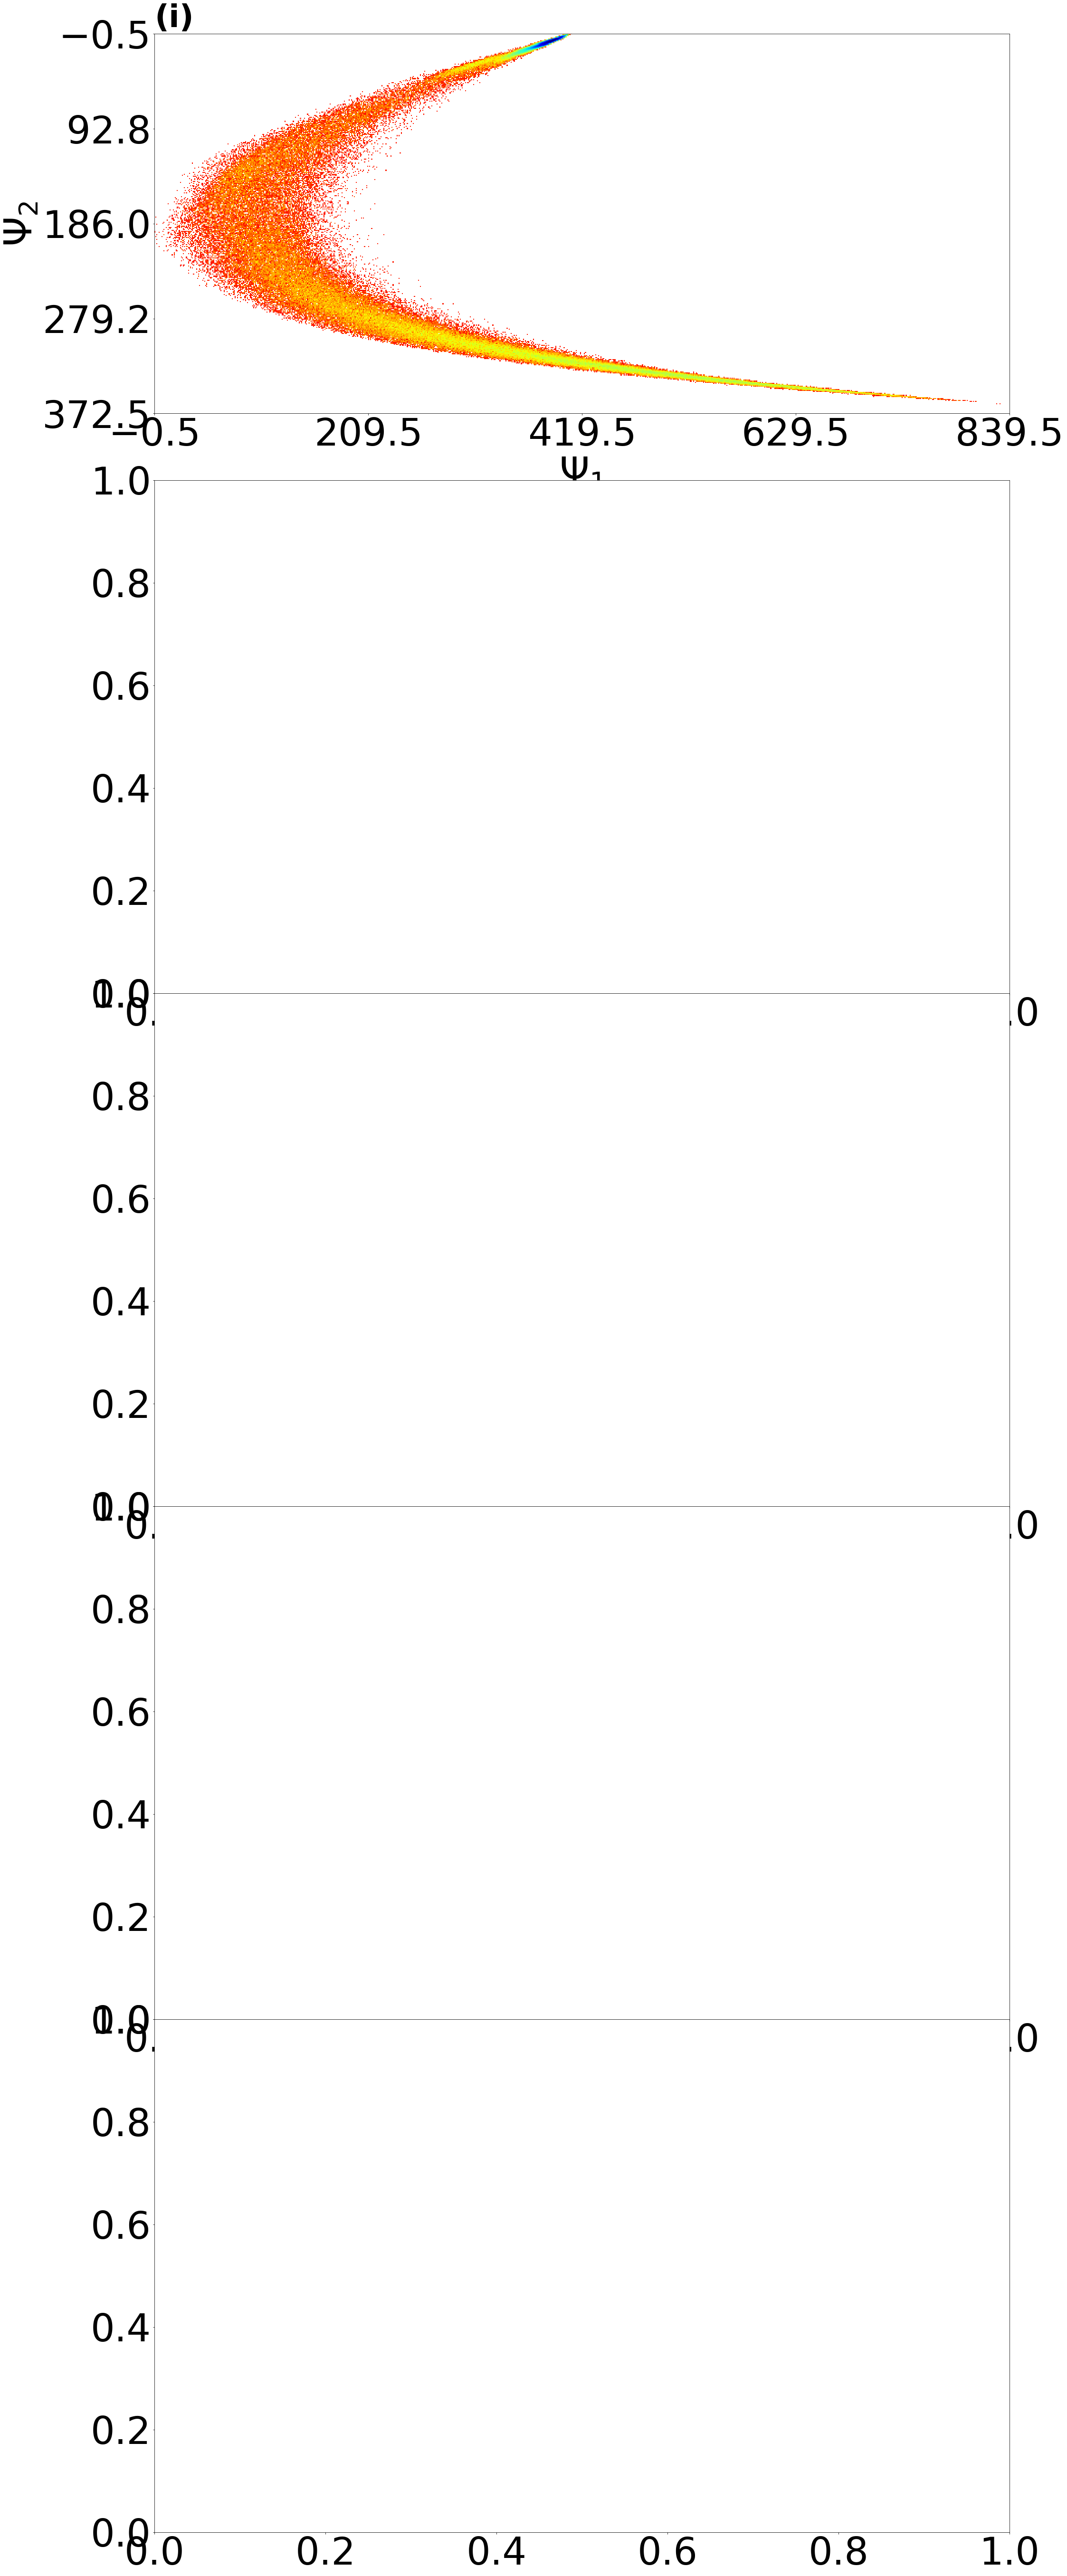

In [7]:

#ONE PLOT STYLE



#xlbl = [[],[],[],[],[]]
#ylbl = [[],[],[],[],[]]
bin_sizes = [1,5,10,25,50]
Dvec = [40000] #,20000,10000,1000 

#bin_sizes = [1]
#Dvec = [40000] 
#xmin=10000
#ymin = 10000
#xmax = -10000
#ymax = -10000
icount = 0

fig, ax = plt.subplots(len(bin_sizes),figsize=(25, 15*len(bin_sizes)))


mpl.rc('xtick', labelsize=80) 
mpl.rc('ytick', labelsize=80)

for Dv in Dvec:
    for binsz in bin_sizes:
        flag = 0
        npzfile = np.load('data_%dk_%fns.npz' %(Dv,binsz*0.2))
        z = npzfile['z']
        zp = z[:,[1,2]]
        
        if binsz==1:
            zp[:,0] = -zp[:,0]
           # zp[:,1] = -zp[:,1]
        
        
        one_max = max(zp[:,0])
        one_min = min(zp[:,0]) 
        two_max = max(zp[:,1])
        two_min = min(zp[:,1])
        
        
        
        
        # move the range so that all numbers are positive
        if one_min < 0: 
            zp[:,0] += abs(one_min)
        elif one_min > 0:
            zp[:,0] -= abs(one_min)
            
        if two_min < 0: 
            zp[:,1] += abs(two_min)
        elif two_min > 0:
            zp[:,1] -= abs(two_min)
        print(int((one_max-one_min)/5e-7),int((two_max-two_min)/5e-7))
            
        # make all elements of zp positive numbers that can correspond to cells
        zp /= 5e-7
        # an assumption of initial conditions
        k_b = 1.38064852e-23
        T = 300
        b = k_b*T

        d_x = int((one_max-one_min)/5e-7)+10
        d_y = int((two_max-two_min)/5e-7)+10

        xp = np.linspace(one_min,one_max,10)
        yp = np.linspace(two_min,two_max,10)

        for i in range(len(xp)):
            xp[i] = round(xp[i],4)
            yp[i] = round(yp[i],4)

        x = range(d_x)
        y= range(d_y)
        xx = range(0,d_x,int(d_x/10))
        yy= range(0,d_y,int(d_y/10))
        # Let's make a free energy landscape

        #Make a lattice in the region in numpy
        lattice = np.zeros([d_x,d_y])
        #lattice = np.empty([d_x,d_y])
        #psi_2 from -0.0001 to 0.0007
        for i in range(len(zp)):
            #resolution in dimensions 1, 2 is 1e-9
            l = int(np.floor(zp[i,0]))
            m = int(np.floor(zp[i,1]))
            #try:
            lattice[l,m] += 1
            #except:
             #   flag +=1
              #  pass

        # normalize probabilities 
        lattice /= len(z)
        # normalize for grid sizing
        lattice *= d_x*d_y
        #deep copy lattice for processing 
        F = deepcopy(lattice)
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                #if F[l,m] !=np.NaN:
                    F[l,m] = -np.log(F[l,m]) #+ 7.135528098680009

        Fp = list(F)
        maxi =0
        for i in range(len(Fp)):
            Fpp = min(Fp[i])
            if maxi > Fpp:
                maxi = Fpp
        print(maxi)
        
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                    F[l,m] -= maxi
                elif F[l,m] ==0:
                    F[l,m] = np.NaN

        #Heatmap 1
       # fig, ax = plt.subplots(2,figsize=(25, 15*len(bin_sizes)))
       # fig, ax = plt.subplots(figsize=(25, 15))
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
       # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.3, wspace = 0.5)
        ax[icount].imshow(F, cmap='jet', interpolation='nearest', vmin=0, vmax=10.5)
        ax[icount].set_xlabel('$\Psi_1$', fontsize=80)
        ax[icount].set_ylabel('$\Psi_2$', fontsize=80)
        #plt.xlim(left = (y[0]- abs(y[0])*0.1),right = (y[-1]+ abs(y[-1])*0.1))
        #plt.ylim((x[0]- abs(x[0])*0.1),(x[-1]+ abs(x[-1])*0.1))
        
        axes = ['(i)','(ii)','(iii)','(iv)','(v)']
        ax[icount].set_title(axes[icount],loc='left',fontsize=66,fontweight="bold")

       # ax[icount].set_xlim(left = xmin,right = xmax)
     #   ax[icount].set_ylim(ymin-10,ymax)
        
         
        yl = ax[icount].get_ylim()
        xl = ax[icount].get_xlim()
                     
        yrng = np.linspace(one_min,one_max,5)
        xrng =  np.linspace(two_min,two_max,5)
       
        xlrng = np.linspace(float(xl[0]),float(xl[1]),5)
        ylrng = np.linspace(float(yl[0]),float(yl[1]),5) #
        
   #     xlrng = np.linspace(0,d_x+10,5)
   #     ylrng = np.linspace(0,d_y+10,5)
    #
        #ax1.set_yticklabels(["one", "two", "three", "four"], rotation=45)
        
        for i in range(len(xrng)):
           # xrng[i] = np.float(format(np.float(np.format_float_positional(xrng[i],precision=7,trim='k')), '.7f'))
            xrng[i] = np.format_float_scientific(xrng[i],precision=0,trim='-')#format(np.float(),'.7e'))

        for i in range(len(yrng)):
            yrng[i] = np.format_float_scientific(yrng[i],precision=0,trim='-')


        
        ax[icount].set_xticks(xlrng)
        ax[icount].set_yticks(ylrng)
     
        #ax[icount].tick_params(axis='x', labelrotation=60)
        ax[icount].set_xticklabels(xlbl[icount],rotation=60)
        ax[icount].set_yticklabels(ylbl[icount])
        
        
        
        ax[icount].arrow(zp[27211,1], zp[27211,0], 0, 80-5*icount, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')
        
        
       
        ax[icount].arrow(zp[83065,1], zp[83065,0], 70-5*icount, 70-5*icount, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')
        
        #a
        
        if icount==0 or icount==2:
            ax[icount].text(zp[17230,1]+65*1.3-6*icount, zp[17230,0]-20-icount*1, 'a',fontsize=80)#, horizontalalignment='left', verticalalignment='center')#, transform=ax1.transAxes)
            ax[icount].arrow(zp[17230,1], zp[17230,0], 50+3*icount,-25, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')
      
        else:
            ax[icount].text(zp[17230,1]-80*1.3+7*icount, zp[17230,0]+15-icount*1, 'a',fontsize=80)#, horizontalalignment='left', verticalalignment='center')#, transform=ax1.transAxes)
            ax[icount].arrow(zp[17230,1], zp[17230,0], -50+3*icount,5, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')
        #b
        ax[icount].text(zp[27211,1] -10, zp[27211,0]+110*1.3-10*icount, 'b',fontsize=80)
        
        #c
        if icount==4 or icount==3:
            ax[icount].text(zp[40100,1]+ -10 , zp[40100,0]+65*1.5-9*icount, 'e',fontsize=80)
            ax[icount].arrow(zp[40100,1], zp[40100,0], 0, 45-5*icount, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')  
        else:
            ax[icount].text(zp[40100,1]+ -10 , zp[40100,0]-55+6*icount, 'e',fontsize=80)
            ax[icount].arrow(zp[40100,1], zp[40100,0], 0, -30+4*icount, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')
        
        
        #d
        if icount==3:
            ax[icount].text(zp[58718,1]+10 -20+icount*2 , zp[58718,0]-90*1.3+8*icount, 'd',fontsize=80)
            ax[icount].arrow(zp[58718,1]+10, zp[58718,0], 0, -80+5*icount, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')
        elif icount==2:
            ax[icount].text(zp[58718,1]-5+ -20+icount*2 , zp[58718,0]-90*1.3+8*icount, 'd',fontsize=80)
            ax[icount].arrow(zp[58718,1]-5, zp[58718,0], 0, -80+5*icount, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')
        
        else:
            ax[icount].text(zp[58718,1]+ -20+icount*2 , zp[58718,0]-90*1.3+8*icount, 'd',fontsize=80)
            ax[icount].arrow(zp[58718,1], zp[58718,0], 0, -80+5*icount, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')
        
        #e
        
        
        ax[icount].text(zp[83065,1]+ 88 -6*icount, zp[83065,0]+80*1.3-6*icount, 'c',fontsize=80)
        
        #plt.xticks(xlrng,xrng,fontsize=80)
       ## plt.yticks(ylrng,yrng,fontsize=46)
        #plt.tick_params(axis='x', labelrotation=60)
       
        
        #plt.tick_params(left = False, right = False,labelleft = False,labelbottom = False, bottom = False)
        icount +=1
        #cbar = plt.colorbar()
        #cbar.ax.tick_params(labelsize=50)
        #plt.scatter(zp[58718,1], zp[58718,0], facecolor='magenta',s=300)
        #plt.scatter(zp[40100,1], zp[40100,0], facecolor='cyan',s=300)
        #plt.scatter(zp[27211,1], zp[27211,0], facecolor='green',s=300)
        #plt.scatter(zp[17230,1], zp[17230,0], facecolor='blue',s=300)
        #plt.scatter(zp[83065,1], zp[83065,0], facecolor='yellow',s=300)
        #print()
        
        #findglobal min and max
        #if one_max>xmax:
         #   xmax = one_max
        #if one_min<xmin:
        #    xmin = one_min
        #if two_max>ymax:
         #   ymax = two_max
        #if two_min<ymin:
         #   ymin = two_min
        #findglobal min and max
    
        #plt.gca().invert_yaxis()
    fig.tight_layout(rect=[0,0,0.99,0.99])    
    plt.show()
     
    fig.savefig('Chignolin_smFES_%dk.png' %(Dv), dpi=300)
        
        #print(flag)
        #fig.savefig('Chig_map_gen_%dk_%fns.png' %(Dv,b*0.2), dpi=300)

In [34]:
szmat=[]
szmat.append(363*830)
szmat.append(232*647)
szmat.append(207*645)
szmat.append(201*561)
szmat.append(201*486)

scalemat =[1.5]
for i in range(1,len(szmat)):
    scalemat.append(szmat[i]/szmat[2])
print(scalemat)

[1.5, 1.124248211811407, 1.0, 0.844556791371756, 0.7316481294236603]


363 830
-8.706696249462183


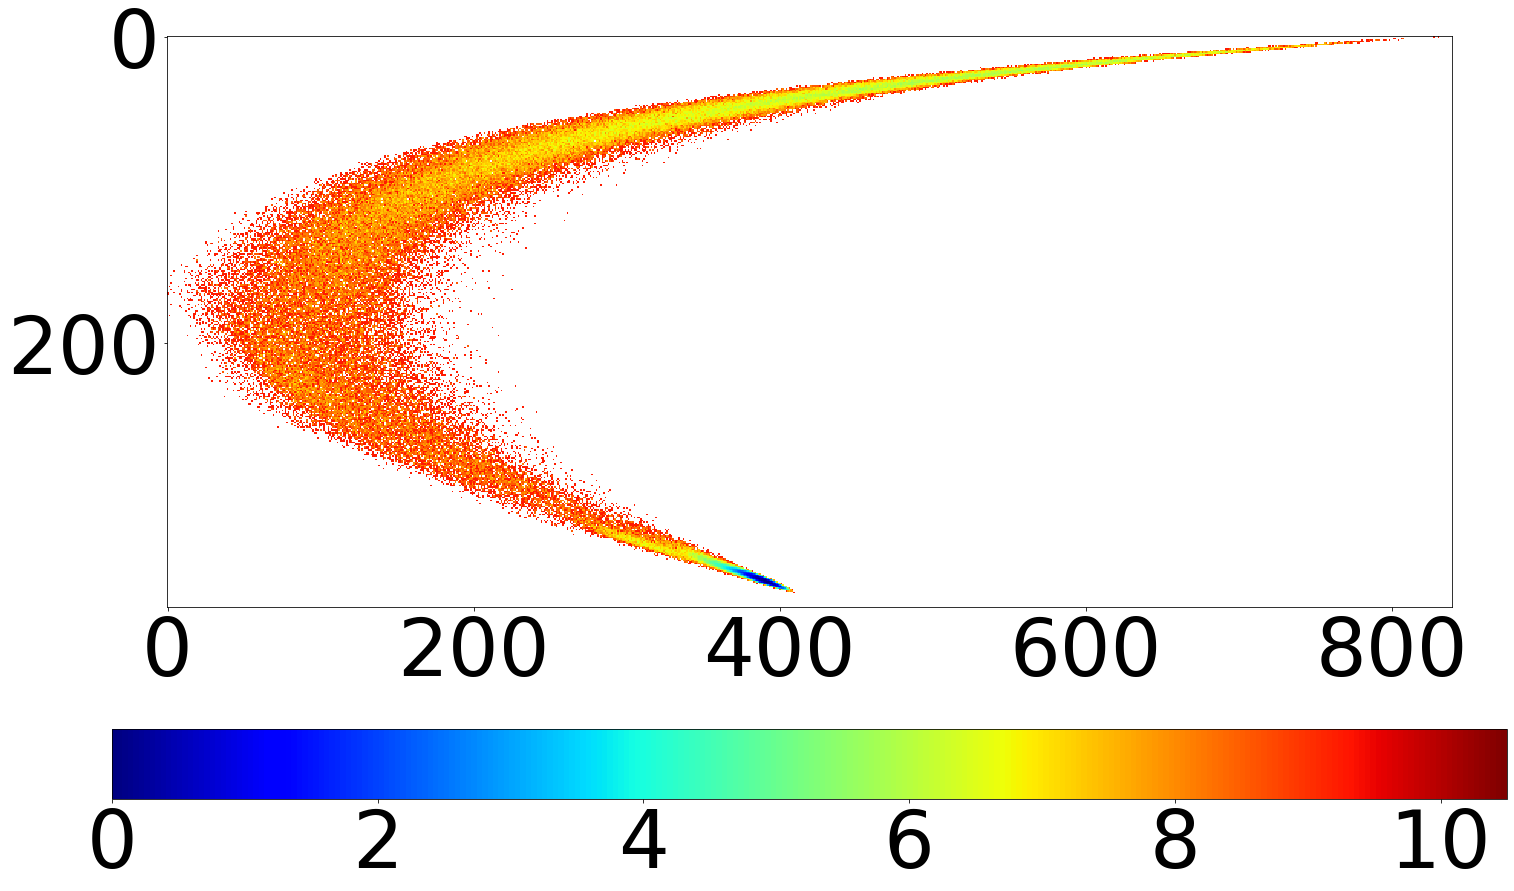

232 647
-9.207216397616309


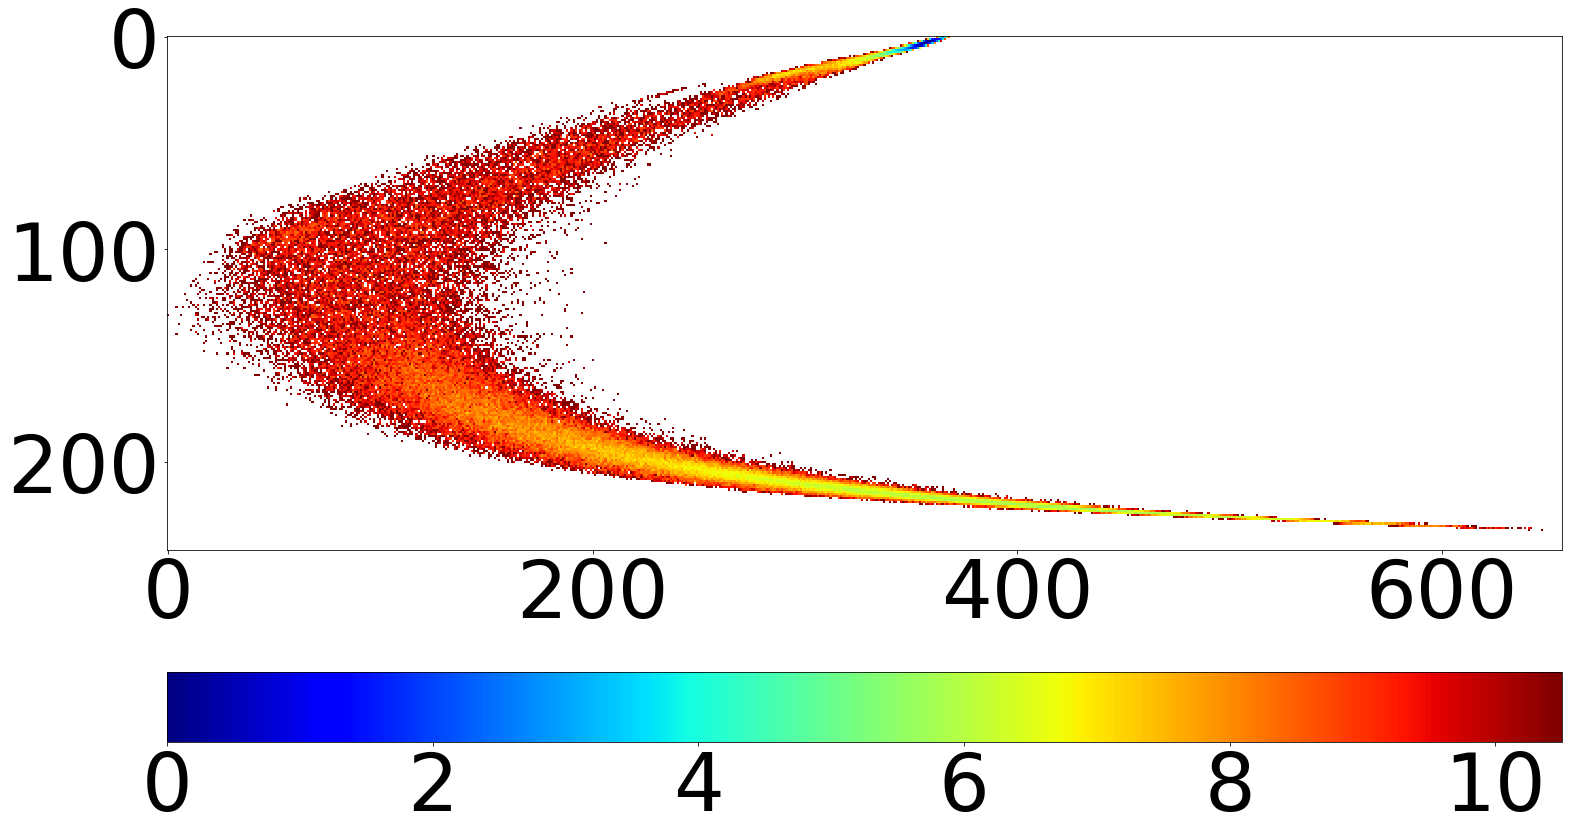

207 645
-9.416202206749132


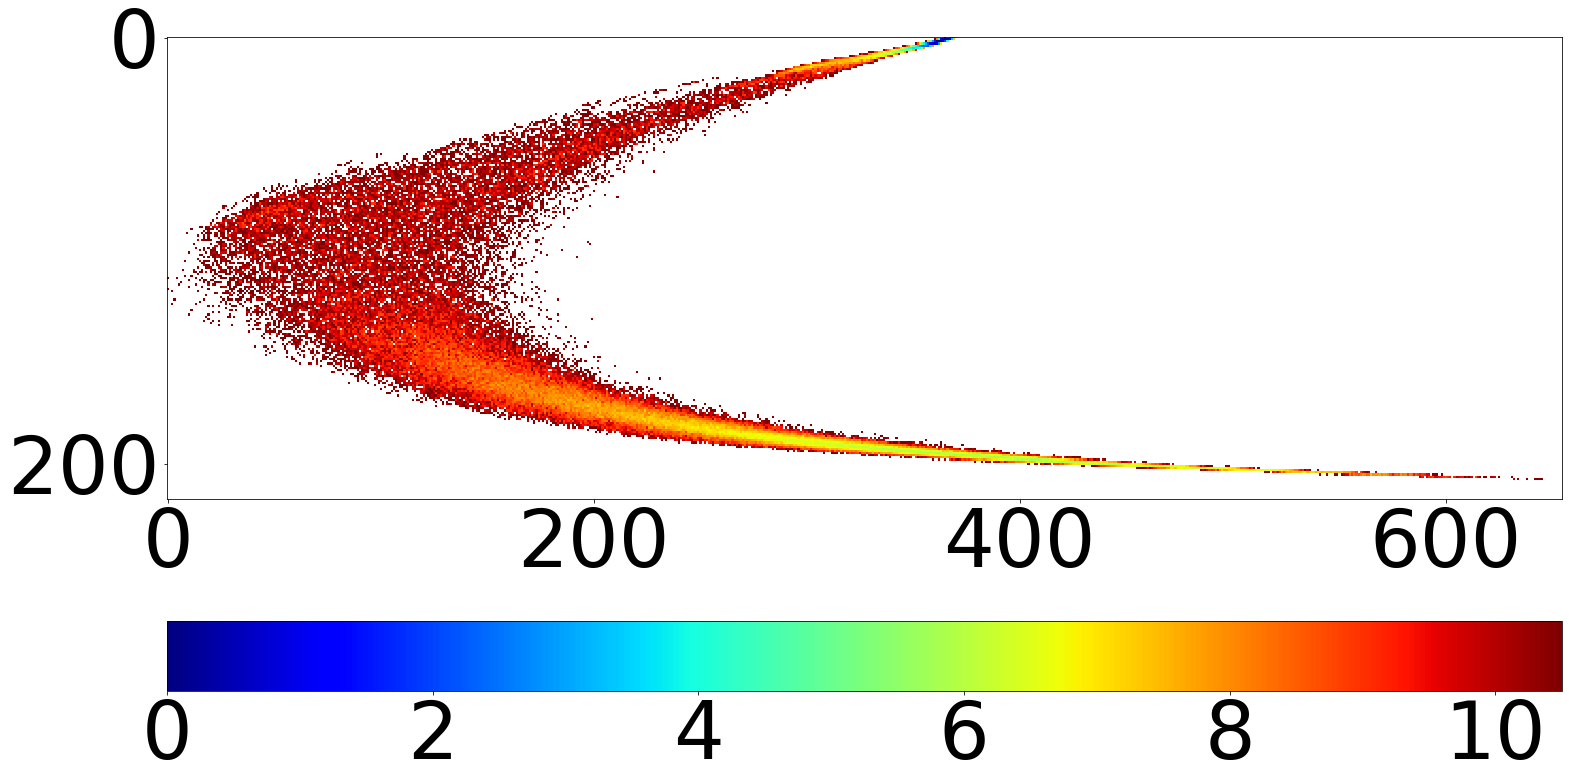

201 561
-9.117156832032103


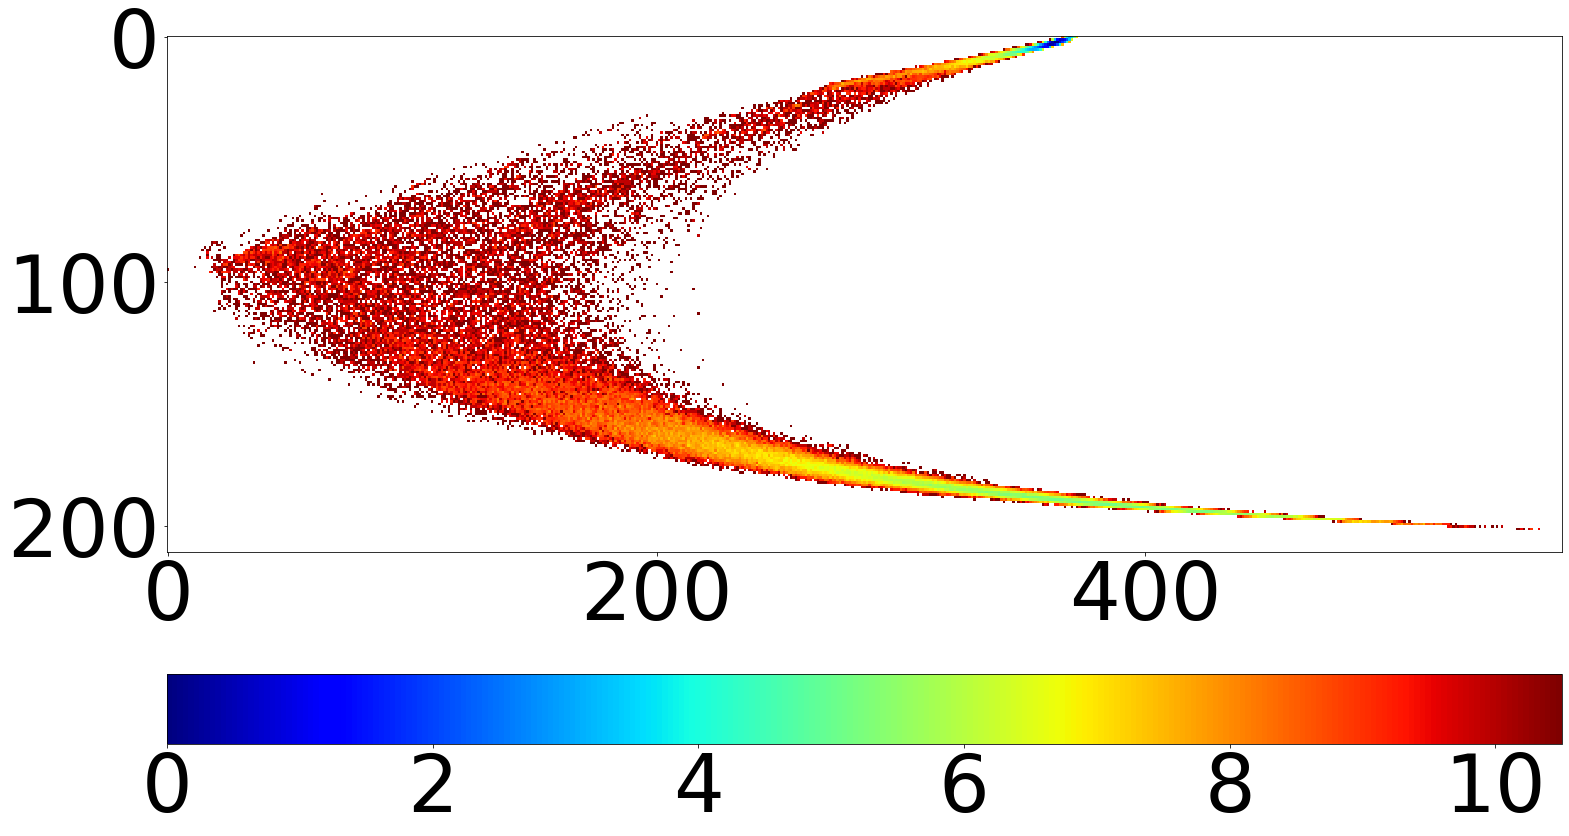

201 486
-8.952948474460312


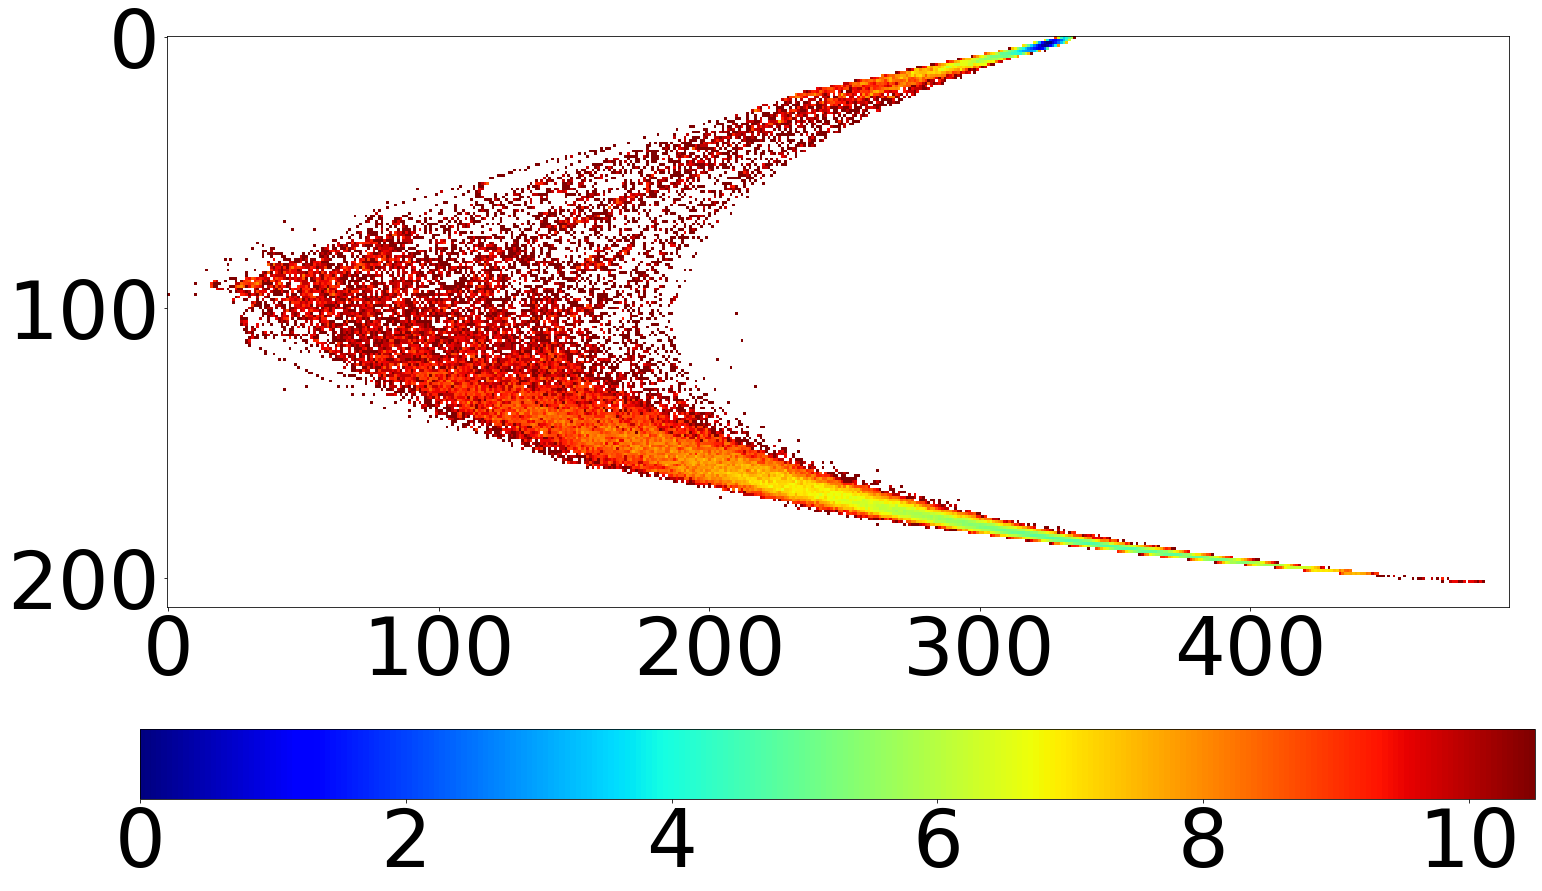

In [30]:
bin_sizes = [1,5,10,25,50]
Dvec = [40000] #,20000,10000,1000 

#bin_sizes = [1]
#Dvec = [40000] 
xmin=10000
ymin = 10000
xmax = -10000
ymax = -10000
icount = 0
for Dv in Dvec:
    for binsz in bin_sizes:
        flag = 0
        npzfile = np.load('data_%dk_%fns.npz' %(Dv,binsz*0.2))
        z = npzfile['z']
        zp = z[:,[1,2]]
        one_max = max(zp[:,0])
        one_min = min(zp[:,0]) 
        two_max = max(zp[:,1])
        two_min = min(zp[:,1])
        
        
        
        
        # move the range so that all numbers are positive
        if one_min < 0: 
            zp[:,0] += abs(one_min)
        elif one_min > 0:
            zp[:,0] -= abs(one_min)
            
        if two_min < 0: 
            zp[:,1] += abs(two_min)
        elif two_min > 0:
            zp[:,1] -= abs(two_min)
        print(int((one_max-one_min)/5e-7),int((two_max-two_min)/5e-7))
            
        # make all elements of zp positive numbers that can correspond to cells
        zp /= 5e-7
        # an assumption of initial conditions
        k_b = 1.38064852e-23
        T = 300
        b = k_b*T

        d_x = int((one_max-one_min)/5e-7)+10
        d_y = int((two_max-two_min)/5e-7)+10

        xp = np.linspace(one_min,one_max,10)
        yp = np.linspace(two_min,two_max,10)

        for i in range(len(xp)):
            xp[i] = round(xp[i],4)
            yp[i] = round(yp[i],4)

        x = range(d_x)
        y= range(d_y)
        xx = range(0,d_x,int(d_x/10))
        yy= range(0,d_y,int(d_y/10))
        # Let's make a free energy landscape

        #Make a lattice in the region in numpy
        lattice = np.zeros([d_x,d_y])
        #lattice = np.empty([d_x,d_y])
        #psi_2 from -0.0001 to 0.0007
        for i in range(len(zp)):
            #resolution in dimensions 1, 2 is 1e-9
            l = int(np.floor(zp[i,0]))
            m = int(np.floor(zp[i,1]))
            #try:
            lattice[l,m] += 1
            #except:
             #   flag +=1
              #  pass

        # normalize probabilities 
        lattice /= len(z)
        # normalize for grid sizing
        lattice *= d_x*d_y
        #deep copy lattice for processing 
        F = deepcopy(lattice)
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                #if F[l,m] !=np.NaN:
                    F[l,m] = -np.log(F[l,m]) #+ 7.135528098680009

        Fp = list(F)
        maxi =0
        for i in range(len(Fp)):
            Fpp = min(Fp[i])
            if maxi > Fpp:
                maxi = Fpp
        print(maxi)
        
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                    F[l,m] -= maxi
                elif F[l,m] ==0:
                    F[l,m] = np.NaN

        #Heatmap 1
       # fig, ax = plt.subplots(2,figsize=(25, 15*len(bin_sizes)))
        fig, ax = plt.subplots(figsize=(25, 15))
        plt.imshow(F, cmap='jet', interpolation='nearest', vmin=0, vmax=10.5)
       # ax.set_xlabel('$\Psi_1$', fontsize=50)#,loc="right")
        #ax.set_ylabel('$\Psi_2$', fontsize=50)#,loc="top")
       # ax.set_ylabel('$\Beta$ F',fontsize=50)
        #plt.xlim(left = (y[0]- abs(y[0])*0.1),right = (y[-1]+ abs(y[-1])*0.1))
        #plt.ylim((x[0]- abs(x[0])*0.1),(x[-1]+ abs(x[-1])*0.1))
        
        #plt.xlim(left = xmin,right = xmax)
       # plt.ylim(ymin,ymax)
        
       # plt.xticks(xlrng,xrng,fontsize = 46)
       # plt.yticks(ylrng,yrng,fontsize = 46)
        #plt.tick_params(left = False, right = False,labelleft = False,labelbottom = False, bottom = False)
        
       # cbar = plt.colorbar(ticks=[0,2,4,6,8,10],orientation='horizontal')
        # ax2.yaxis.tick_right()
     #   ax2.yaxis.set_label_position("right")
       # ax.set_ylabel('$\beta$ F')#,loc="right")
        #plt.scatter(zp[58718,1], zp[58718,0], facecolor='magenta',s=300)
        #plt.scatter(zp[40100,1], zp[40100,0], facecolor='cyan',s=300)
        #plt.scatter(zp[27211,1], zp[27211,0], facecolor='green',s=300)
        #plt.scatter(zp[17230,1], zp[17230,0], facecolor='blue',s=300)
        #plt.scatter(zp[83065,1], zp[83065,0], facecolor='yellow',s=300)
        #print()
        
        #findglobal min and max
        #if one_max>xmax:
         #   xmax = one_max
        #if one_min<xmin:
        #    xmin = one_min
        #if two_max>ymax:
         #   ymax = two_max
        #if two_min<ymin:
         #   ymin = two_min
        #findglobal min and max
       # plt.tick_params(axis='x', labelrotation=60)
        #plt.gca().invert_yaxis()
        plt.show()
        
        fig.savefig('Chignolin_smFES_%dk_%fns.png' %(Dv,binsz*0.2), dpi=300)
  
        icount +=1
        
        #print(flag)
        #fig.savefig('Chig_map_gen_%dk_%fns.png' %(Dv,b*0.2), dpi=300)

363 830
-8.702907814215715
[-1.7e-04 -6.2e-05  4.2e-05  1.5e-04  2.5e-04]
[-8.4e-05 -3.9e-05  6.8e-06  5.2e-05  9.8e-05]
232 647
-9.207216397616309
[-1.7e-04 -8.5e-05 -3.6e-06  7.7e-05  1.6e-04]
[-6.0e-05 -3.1e-05 -2.1e-06  2.7e-05  5.6e-05]
207 645
-9.416202206749132
[-1.7e-04 -9.1e-05 -1.1e-05  7.0e-05  1.5e-04]
[-5.3e-05 -2.7e-05 -7.1e-07  2.5e-05  5.1e-05]
201 561
-9.117156832032103
[-1.7e-04 -9.7e-05 -2.7e-05  4.3e-05  1.1e-04]
[-5.7e-05 -3.2e-05 -6.8e-06  1.8e-05  4.4e-05]
201 486
-8.952948474460312
[-1.4e-04 -8.2e-05 -2.1e-05  3.9e-05  1.0e-04]
[-5.4e-05 -2.8e-05 -3.2e-06  2.2e-05  4.7e-05]


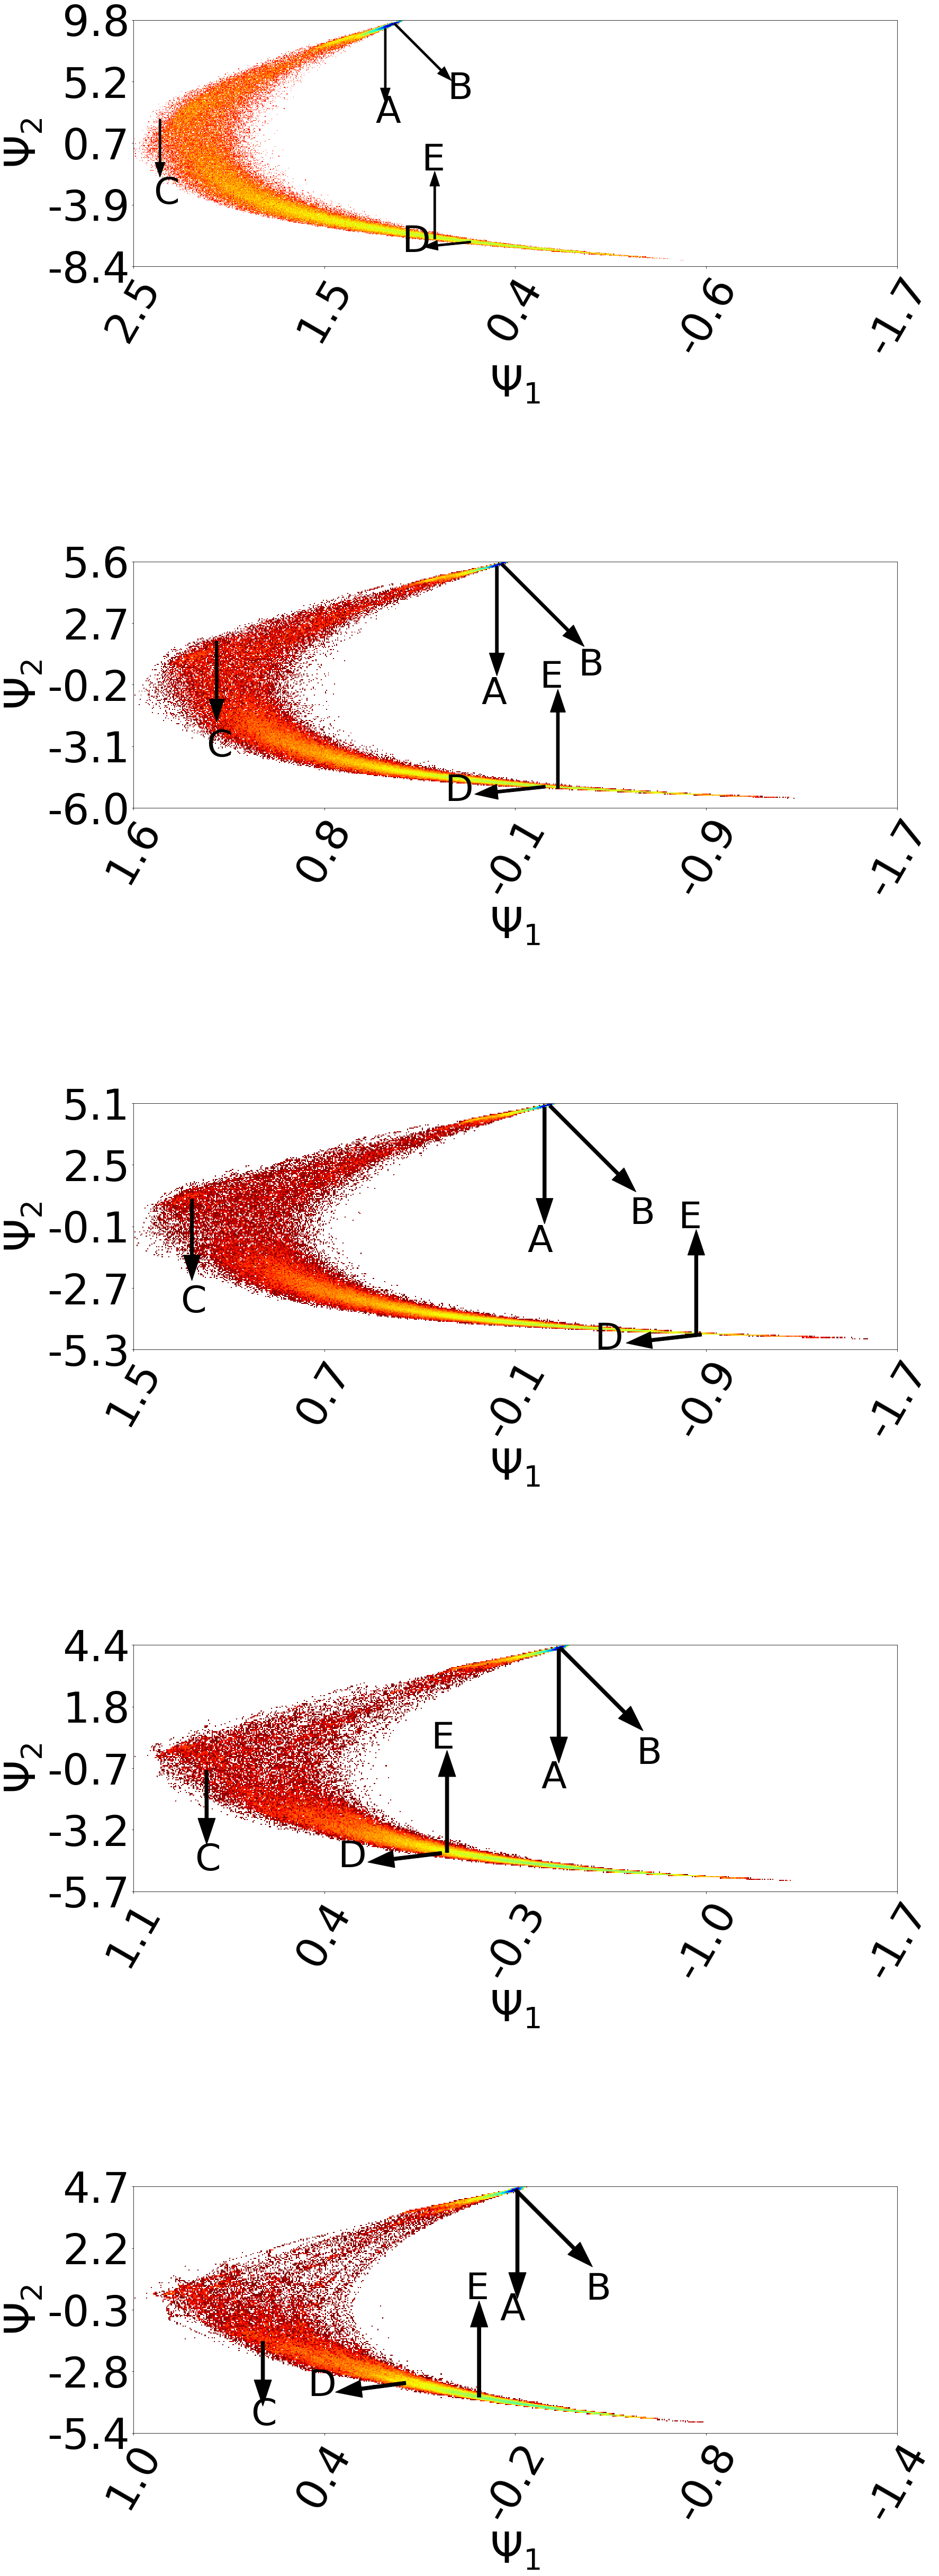

[-2.25201072386059, -2.7148760330578514, -3.0184331797235022, -2.706161137440758, -2.3507109004739335]


In [35]:

#ONE PLOT STYLE

limit=[]
#xlbl = [[],[],[],[],[]]
#ylbl = [[],[],[],[],[]]
bin_sizes = [1,5,10,25,50]
Dvec = [40000] #,20000,10000,1000 

#bin_sizes = [1]
#Dvec = [40000] 
#xmin=10000
#ymin = 10000
#xmax = -10000
#ymax = -10000
icount = 0

fig, ax = plt.subplots(len(bin_sizes),1,figsize=(25, 15*len(bin_sizes)),gridspec_kw={'height_ratios': [1,1,1,1,1]})

#specify individual sizes for subplots
#fig, ax = plt.subplots(len(bin_sizes), gridspec_kw={'height_ratios': [1,1,1,1,1]})
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

mpl.rc('xtick', labelsize=80)
mpl.rc('ytick', labelsize=80)

for Dv in Dvec:
    for binsz in bin_sizes:
        flag = 0
        npzfile = np.load('data_%dk_%fns.npz' %(Dv,binsz*0.2))
        z = npzfile['z']
        zp = z[:,[1,2]]
        
        if binsz==1:
            zp[:,0] = -zp[:,0]
           # zp[:,1] = -zp[:,1]
        
        
        one_max = max(zp[:,0])
        one_min = min(zp[:,0]) 
        two_max = max(zp[:,1])
        two_min = min(zp[:,1])
        
        
        
        
        # move the range so that all numbers are positive
        if one_min < 0: 
            zp[:,0] += abs(one_min)
        elif one_min > 0:
            zp[:,0] -= abs(one_min)
            
        if two_min < 0: 
            zp[:,1] += abs(two_min)
        elif two_min > 0:
            zp[:,1] -= abs(two_min)
        print(int((one_max-one_min)/5e-7),int((two_max-two_min)/5e-7))
            
        # make all elements of zp positive numbers that can correspond to cells
        zp /= 5e-7
        # an assumption of initial conditions
        k_b = 1.38064852e-23
        T = 300
        b = k_b*T

        d_x = int((one_max-one_min)/5e-7)+10
        d_y = int((two_max-two_min)/5e-7)+10

        xp = np.linspace(one_min,one_max,10)
        yp = np.linspace(two_min,two_max,10)

        for i in range(len(xp)):
            xp[i] = round(xp[i],4)
            yp[i] = round(yp[i],4)

        x = range(d_x)
        y= range(d_y)
        xx = range(0,d_x,int(d_x/10))
        yy= range(0,d_y,int(d_y/10))
        # Let's make a free energy landscape

        #Make a lattice in the region in numpy
        lattice = np.zeros([d_x,d_y])
        #lattice = np.empty([d_x,d_y])
        #psi_2 from -0.0001 to 0.0007
        for i in range(len(zp)):
            #resolution in dimensions 1, 2 is 1e-9
            l = int(np.floor(zp[i,0]))
            m = int(np.floor(zp[i,1]))
            #try:
            lattice[l,m] += 1
            #except:
             #   flag +=1
              #  pass

        # normalize probabilities 
        lattice /= len(z)
        # normalize for grid sizing
        lattice *= d_x*d_y
        #deep copy lattice for processing 
        F = deepcopy(lattice)
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                #if F[l,m] !=np.NaN:
                    F[l,m] = -np.log(F[l,m]) #+ 7.135528098680009

        Fp = list(F)
        maxi =0
        for i in range(len(Fp)):
            Fpp = min(Fp[i])
            if maxi > Fpp:
                maxi = Fpp
        print(maxi)
        
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                    F[l,m] -= maxi
                elif F[l,m] ==0:
                    F[l,m] = np.NaN

        #Heatmap 1
       # fig, ax = plt.subplots(2,figsize=(25, 15*len(bin_sizes)))
       # fig, ax = plt.subplots(figsize=(25, 15))
        
       # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.3, wspace = 0.5)
        
        
        
        ax[icount].imshow(F, cmap='jet', interpolation='nearest', vmin=0, vmax=10.5)
        ax[icount].set_xlabel('$\Psi_1$', fontsize=80)
        ax[icount].set_ylabel('$\Psi_2$', fontsize=80)
        #plt.xlim(left = (y[0]- abs(y[0])*0.1),right = (y[-1]+ abs(y[-1])*0.1))
        #plt.ylim((x[0]- abs(x[0])*0.1),(x[-1]+ abs(x[-1])*0.1))
        
      #  axes = ['(a)','(b)','(c)','(d)','(e)']
       # ax[icount].set_title(axes[icount],loc='left',fontsize=66,fontweight="bold")

       # ax[icount].set_xlim(left = xmin,right = xmax)
     #   ax[icount].set_ylim(ymin-10,ymax)
        
        
        yl = ax[icount].get_ylim()
        xl = ax[icount].get_xlim()
        limit.append((xl[1]-xl[0])/(yl[1]-yl[0]))
        
        yrng = np.linspace(one_min,one_max,5)
        xrng =  np.linspace(two_min,two_max,5)
       
        #xlrng = np.linspace(float(xl[0]),float(xl[1]),5)
        xlrng = np.linspace(float(yl[0]*3.1),float(yl[1])*3.1,5)
        ylrng = np.linspace(float(yl[0]),float(yl[1]),5) #
        
   #     xlrng = np.linspace(0,d_x+10,5)
   #     ylrng = np.linspace(0,d_y+10,5)
    #
        #ax1.set_yticklabels(["one", "two", "three", "four"], rotation=45)
        
        for i in range(len(xrng)):
           # xrng[i] = np.float(format(np.float(np.format_float_positional(xrng[i],precision=7,trim='k')), '.7f'))
            xrng[i] = np.format_float_scientific(xrng[i],precision=1,trim='-')#format(np.float(),'.7e'))

        for i in range(len(yrng)):
            yrng[i] = np.format_float_scientific(yrng[i],precision=1,trim='-')


        print(xrng)
        print(yrng)
        ax[icount].set_xticks(xlrng)
        ax[icount].set_yticks(ylrng)
     
        #ax[icount].tick_params(axis='x', labelrotation=60)
        ax[icount].set_xticklabels(xlbl[icount],rotation=60)
        ax[icount].set_yticklabels(ylbl[icount])
        
        
        ax[icount].arrow(zp[17230,1], zp[17230,0], -50+3*icount,5, head_width = 15, width = 3,color='black')
        ax[icount].arrow(zp[27211,1], zp[27211,0], 0, 90-5*icount, head_width = 15, width = 3,color='black')
        ax[icount].arrow(zp[40100,1], zp[40100,0], 0, 65-8*icount, head_width = 15, width = 3,color='black')
        ax[icount].arrow(zp[58718,1], zp[58718,0], 0, -80+5*icount, head_width = 15, width = 3,color='black')
        ax[icount].arrow(zp[83065,1], zp[83065,0], 70-5*icount, 70-5*icount, head_width = 15, width = 3,color='black')
        
        ax[icount].text(zp[17230,1]-80*1.3+5*icount, zp[17230,0]+15-icount*1, 'D',fontsize=70)#, horizontalalignment='left', verticalalignment='center')#, transform=ax1.transAxes)
        ax[icount].text(zp[27211,1] -15, zp[27211,0]+110*1.3-8*icount, 'A',fontsize=70)
        ax[icount].text(zp[40100,1]+ -10 , zp[40100,0]+85*1.5-14*icount, 'C',fontsize=70)
        ax[icount].text(zp[58718,1]+ -20+icount*2 , zp[58718,0]-80*1.3+5*icount, 'E',fontsize=70)
        ax[icount].text(zp[83065,1]+ 80 -5*icount, zp[83065,0]+80*1.3-5*icount+10, 'B',fontsize=70)
        
        #plt.xticks(xlrng,xrng,fontsize=80)
       ## plt.yticks(ylrng,yrng,fontsize=46)
        #plt.tick_params(axis='x', labelrotation=60)
       
        
        #plt.tick_params(left = False, right = False,labelleft = False,labelbottom = False, bottom = False)
        icount +=1
        #cbar = plt.colorbar()
        #cbar.ax.tick_params(labelsize=50)
        #plt.scatter(zp[58718,1], zp[58718,0], facecolor='magenta',s=300)
        #plt.scatter(zp[40100,1], zp[40100,0], facecolor='cyan',s=300)
        #plt.scatter(zp[27211,1], zp[27211,0], facecolor='green',s=300)
        #plt.scatter(zp[17230,1], zp[17230,0], facecolor='blue',s=300)
        #plt.scatter(zp[83065,1], zp[83065,0], facecolor='yellow',s=300)
        #print()
        
        #findglobal min and max
        #if one_max>xmax:
         #   xmax = one_max
        #if one_min<xmin:
        #    xmin = one_min
        #if two_max>ymax:
         #   ymax = two_max
        #if two_min<ymin:
         #   ymin = two_min
        #findglobal min and max
    
        #plt.gca().invert_yaxis()
    fig.tight_layout(rect=[0,0,0.99,0.99])    
    plt.show()
     
    fig.savefig('Chignolin_smFES_%dk.png' %(Dv), dpi=300)
    print(limit)
        #print(flag)
        #fig.savefig('Chig_map_gen_%dk_%fns.png' %(Dv,b*0.2), dpi=300)

In [34]:
print(limit)

[-2.25201072386059, -2.7148760330578514, -3.0184331797235022, -2.706161137440758, -2.3507109004739335]


In [5]:
xlbl = [[],[],[],[],[]]
ylbl = [[],[],[],[],[]]

xlbl[0]=[-1.7,-0.6,0.4,1.5,2.5]    #e4/e5
ylbl[0]=[-8.4, -3.9, 0.7,  5.2,  9.8]

xlbl[1]=[-1.7, -0.9, -0.1,  0.8,  1.6]
ylbl[1]=[-6.0, -3.1, -0.2,  2.7,  5.6]

xlbl[2]=[-1.7, -0.9, -0.1,  0.7,  1.5]
ylbl[2]=[-5.3, -2.7, -0.1,  2.5,  5.1]

xlbl[3]=[-1.7, -1.0, -0.3,  0.4,  1.1]
ylbl[3]=[-5.7, -3.2, -0.7,  1.8,  4.4]

xlbl[4]=[-1.4, -0.8, -0.2,  0.4,  1.0]
ylbl[4]=[-5.4, -2.8, -0.3, 2.2,  4.7]





363 830
-8.702907814215715


AttributeError: module 'matplotlib.axes' has no attribute 'fig'

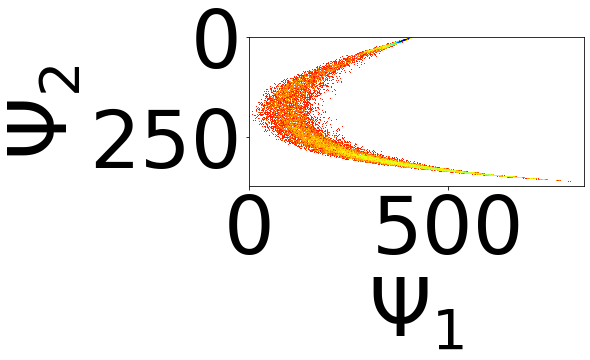

In [15]:

#ONE PLOT STYLE



#xlbl = [[],[],[],[],[]]
#ylbl = [[],[],[],[],[]]
bin_sizes = [1,5,10,25,50]
Dvec = [40000] #,20000,10000,1000 

#bin_sizes = [1]
#Dvec = [40000] 
#xmin=10000
#ymin = 10000
#xmax = -10000
#ymax = -10000
icount = 0



for Dv in Dvec:
    for binsz in bin_sizes:
        
        fig = plt.plot(figsize=(25, 15))


        mpl.rc('xtick', labelsize=80) 
        mpl.rc('ytick', labelsize=80)
        flag = 0
        npzfile = np.load('data_%dk_%fns.npz' %(Dv,binsz*0.2))
        z = npzfile['z']
        zp = z[:,[1,2]]
        
        if binsz==1:
            zp[:,0] = -zp[:,0]
           # zp[:,1] = -zp[:,1]
        
        
        one_max = max(zp[:,0])
        one_min = min(zp[:,0]) 
        two_max = max(zp[:,1])
        two_min = min(zp[:,1])
        
        
        
        
        # move the range so that all numbers are positive
        if one_min < 0: 
            zp[:,0] += abs(one_min)
        elif one_min > 0:
            zp[:,0] -= abs(one_min)
            
        if two_min < 0: 
            zp[:,1] += abs(two_min)
        elif two_min > 0:
            zp[:,1] -= abs(two_min)
        print(int((one_max-one_min)/5e-7),int((two_max-two_min)/5e-7))
            
        # make all elements of zp positive numbers that can correspond to cells
        zp /= 5e-7
        # an assumption of initial conditions
        k_b = 1.38064852e-23
        T = 300
        b = k_b*T

        d_x = int((one_max-one_min)/5e-7)+10
        d_y = int((two_max-two_min)/5e-7)+10

        xp = np.linspace(one_min,one_max,10)
        yp = np.linspace(two_min,two_max,10)

        for i in range(len(xp)):
            xp[i] = round(xp[i],4)
            yp[i] = round(yp[i],4)

        x = range(d_x)
        y= range(d_y)
        xx = range(0,d_x,int(d_x/10))
        yy= range(0,d_y,int(d_y/10))
        # Let's make a free energy landscape

        #Make a lattice in the region in numpy
        lattice = np.zeros([d_x,d_y])
        #lattice = np.empty([d_x,d_y])
        #psi_2 from -0.0001 to 0.0007
        for i in range(len(zp)):
            #resolution in dimensions 1, 2 is 1e-9
            l = int(np.floor(zp[i,0]))
            m = int(np.floor(zp[i,1]))
            #try:
            lattice[l,m] += 1
            #except:
             #   flag +=1
              #  pass

        # normalize probabilities 
        lattice /= len(z)
        # normalize for grid sizing
        lattice *= d_x*d_y
        #deep copy lattice for processing 
        F = deepcopy(lattice)
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                #if F[l,m] !=np.NaN:
                    F[l,m] = -np.log(F[l,m]) #+ 7.135528098680009

        Fp = list(F)
        maxi =0
        for i in range(len(Fp)):
            Fpp = min(Fp[i])
            if maxi > Fpp:
                maxi = Fpp
        print(maxi)
        
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                    F[l,m] -= maxi
                elif F[l,m] ==0:
                    F[l,m] = np.NaN

        #Heatmap 1
       # fig, ax = plt.subplots(2,figsize=(25, 15*len(bin_sizes)))
       # fig, ax = plt.subplots(figsize=(25, 15))
        #plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
       # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.3, wspace = 0.5)
        plt.imshow(F, cmap='jet', interpolation='nearest', vmin=0, vmax=10.5)
        plt.xlabel('$\Psi_1$', fontsize=80)
        plt.ylabel('$\Psi_2$', fontsize=80)
        #plt.xlim(left = (y[0]- abs(y[0])*0.1),right = (y[-1]+ abs(y[-1])*0.1))
        #plt.ylim((x[0]- abs(x[0])*0.1),(x[-1]+ abs(x[-1])*0.1))
        
      #  axes = ['(a)','(b)','(c)','(d)','(e)']
       # ax[icount].set_title(axes[icount],loc='left',fontsize=66,fontweight="bold")

       # ax[icount].set_xlim(left = xmin,right = xmax)
     #   ax[icount].set_ylim(ymin-10,ymax)
        
         
        yl = mpl.axes.fig.get_ylim()
        xl = mpl.axes.fig.get_xlim()
                     
        yrng = np.linspace(one_min,one_max,5)
        xrng =  np.linspace(two_min,two_max,5)
       
        xlrng = np.linspace(float(xl[0]),float(xl[1]),5)
        ylrng = np.linspace(float(yl[0]),float(yl[1]),5) #
        
   #     xlrng = np.linspace(0,d_x+10,5)
   #     ylrng = np.linspace(0,d_y+10,5)
    #
        #ax1.set_yticklabels(["one", "two", "three", "four"], rotation=45)
        
        for i in range(len(xrng)):
           # xrng[i] = np.float(format(np.float(np.format_float_positional(xrng[i],precision=7,trim='k')), '.7f'))
            xrng[i] = np.format_float_scientific(xrng[i],precision=1,trim='-')#format(np.float(),'.7e'))

        for i in range(len(yrng)):
            yrng[i] = np.format_float_scientific(yrng[i],precision=1,trim='-')


        print(xrng)
        print(yrng)
        plt.xticks(xlrng)
        plt.yticks(ylrng)
     
        #ax[icount].tick_params(axis='x', labelrotation=60)
        plt.xtick(xlbl[icount],rotation=60)
        plt.ytick(ylbl[icount])
        
        
        plt.arrow(zp[17230,1], zp[17230,0], -50+3*icount,5, head_width = 15, width = 3,color='black')
        plt.arrow(zp[27211,1], zp[27211,0], 0, 90-5*icount, head_width = 15, width = 3,color='black')
        plt.arrow(zp[40100,1], zp[40100,0], 0, 65-8*icount, head_width = 15, width = 3,color='black')
        plt.arrow(zp[58718,1], zp[58718,0], 0, -80+5*icount, head_width = 15, width = 3,color='black')
        plt.arrow(zp[83065,1], zp[83065,0], 70-5*icount, 70-5*icount, head_width = 15, width = 3,color='black')
        
        plt.text(zp[17230,1]-80*1.3+5*icount, zp[17230,0]+15-icount*1, 'D',fontsize=70)#, horizontalalignment='left', verticalalignment='center')#, transform=ax1.transAxes)
        plt.text(zp[27211,1] -15, zp[27211,0]+110*1.3-8*icount, 'A',fontsize=70)
        plt.text(zp[40100,1]+ -10 , zp[40100,0]+85*1.5-14*icount, 'C',fontsize=70)
        plt.text(zp[58718,1]+ -20+icount*2 , zp[58718,0]-80*1.3+5*icount, 'E',fontsize=70)
        plt.text(zp[83065,1]+ 80 -5*icount, zp[83065,0]+80*1.3-5*icount+10, 'B',fontsize=70)
        
        #plt.xticks(xlrng,xrng,fontsize=80)
       ## plt.yticks(ylrng,yrng,fontsize=46)
        #plt.tick_params(axis='x', labelrotation=60)
       
        
        #plt.tick_params(left = False, right = False,labelleft = False,labelbottom = False, bottom = False)
        
        #cbar = plt.colorbar()
        #cbar.ax.tick_params(labelsize=50)
        #plt.scatter(zp[58718,1], zp[58718,0], facecolor='magenta',s=300)
        #plt.scatter(zp[40100,1], zp[40100,0], facecolor='cyan',s=300)
        #plt.scatter(zp[27211,1], zp[27211,0], facecolor='green',s=300)
        #plt.scatter(zp[17230,1], zp[17230,0], facecolor='blue',s=300)
        #plt.scatter(zp[83065,1], zp[83065,0], facecolor='yellow',s=300)
        #print()
        
        #findglobal min and max
        #if one_max>xmax:
         #   xmax = one_max
        #if one_min<xmin:
        #    xmin = one_min
        #if two_max>ymax:
         #   ymax = two_max
        #if two_min<ymin:
         #   ymin = two_min
        #findglobal min and max
    
        #plt.gca().invert_yaxis()
        fig.tight_layout(rect=[0,0,0.99,0.99])    
        plt.show()
     
        fig.savefig('Chignolin_smFES_%dk_no%d.png' %(Dv,icount), dpi=300)
        icount +=1
        

In [20]:
pdb_dir = "/home/maxtopel/Desktop/Desres/CLN/DESRES-Trajectory_CLN025-0-protein/CLN025-0-protein/"
pdb_file = os.path.join(pdb_dir, "system.pdb")

trj_dir = "/home/maxtopel/Desktop/Desres/CLN/DESRES-Trajectory_CLN025-0-protein/CLN025-0-protein/"
trj_file = []
for i in range(10):
    fname = "CLN025-0-protein-00" + str(i) + ".dcd"
    trj_file.append(os.path.join(trj_dir, fname))
for i in range(10,54):
    fname = "CLN025-0-protein-0" + str(i) + ".dcd"
    trj_file.append(os.path.join(trj_dir, fname))
    
# loading
traj_true = md.load(trj_file, top=pdb_file)

# restricting atoms in trajectory
idx_atoms = traj_true.topology.select_atom_indices('heavy') # 'heavy' OR 'minimal' OR 'all'
traj_true = traj_true.atom_slice(idx_atoms)
# rot+trans alignment of trajectory to first frame
traj_true.center_coordinates(mass_weighted=False)
traj_true.superpose(traj_true[0])


traj_true.center_coordinates(mass_weighted=False)
traj_true.superpose(traj_true[0])

print('How many frames? %s' % traj_true.n_frames)
print('How many atoms?    %s' % traj_true.n_atoms)
print(traj_true.xyz.shape)

How many frames? 534743
How many atoms?    93
(534743, 93, 3)


In [14]:
print(zp[17230,1]*5e-7,zp[27211,1]*5e-7,zp[17230,0]*5e-7,zp[27211,0]*5e-7)

0.00011585681373118717 0.00016366255562310064 8.382688683644104e-05 1.5604806152119e-06


In [ ]:
loc = [17230, 27211,40100,58718,83065]
tau = [1,5,10,25,50] 
ti = range(len(tau))
Dvec = [40000,20000,10000,1000] #40000
Id = 100000
dv = 40000
#no of observed photons
Photon_No  = [0,1000000,100000,10000] 



for l in loc:
    

#find Fmin, F max
#Use to create bounds and equally enforce
print(xmin,xmax,ymin,ymax)

gxmin = xmin/5e-7
gymin = ymin/5e-7
gxmax = xmax/5e-7
gymax = ymax/5e-7

In [ ]:
#FORMAT THE LABELING FOR AXES!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



#xmax xmin system good: calibrate with extreme values then put in bounds
#label:
#1) 5 y, 10 x with linspace
#2) round to 3 sig fig.
#3) size 46 std

xrng = np.linspace(xmin,xmax,5)
yrng = np.linspace(ymin,ymax,5)
xlrng = np.linspace(xmin,xmax,5)
ylrng = np.linspace(ymin,ymax,5)

xrng = [item * 5e-7 for item in xrng]
yrng = [item * 5e-7 for item in yrng]

for i in range(len(xrng)):
   # xrng[i] = np.float(format(np.float(np.format_float_positional(xrng[i],precision=7,trim='k')), '.7f'))
    xrng[i] = np.format_float_scientific(xrng[i],precision=0,trim='-')#format(np.float(),'.7e'))
    
    #xrng[i] = np.float("{:g}".format(xrng[i]))#,'.e'))
    #xrng[i] = "{:2e}".format(xrng[i])
    #xrng[i] = str(float(xrng[i]))#,'.e')
   # xrng[i] = format(xrng[i],'.3e')
    

for i in range(len(yrng)):
    yrng[i] = np.format_float_scientific(yrng[i],precision=0,trim='-')
    #yrng[i] =
print(xrng,yrng)

In [5]:
#LABELING MATRIX
xlbl = [[],[],[],[],[]]
ylbl = [[],[],[],[],[]]

xlbl[0]=['-8.e-05','-4.e-05',  '7.e-06',  '5.e-05',  '1.e-04']
ylbl[0]=['-2.e-04', '-6.e-05',  '4.e-05',  '1.e-04',  '3.e-04']

xlbl[1]=['-6.e-05', '-3.e-05', '-2.e-06',  '3.e-05',  '6.e-05']
ylbl[1]=['-2.e-04', '-8.e-05', '-4.e-06',  '8.e-05',  '2.e-04']

xlbl[2]=['-5.e-05','-3.e-05', '-7.e-07',  '3.e-05',  '5.e-05']
ylbl[2]=['-2.e-04', '-9.e-05', '-1.e-05',  '7.e-05',  '2.e-04']

xlbl[3]=['-6.e-05', '-3.e-05', '-7.e-06',  '2.e-05',  '4.e-05']
ylbl[3]=['-2.e-04', '-1.e-04', '-3.e-05',  '4.e-05',  '1.e-04']

xlbl[4]=['-5.e-05', '-3.e-05', '-3.e-06',  '2.e-05',  '5.e-05']
ylbl[4]=['-1.e-04', '-8.e-05', '-2.e-05',  '4.e-05',  '1.e-04']


In [ ]:

fig = plt.figure(figsize=(10, 8)) 
#for Dv in Dvec:
Dv = 40000
binct = 0
for binsz in bin_sizes:
    
    flag = 0
    npzfile = np.load('data_%dk_%fns.npz' %(Dv,binsz*0.2))
    z = npzfile['z']
    zp = z[:,[1,2]]
    one_max = max(zp[:,0])
    one_min = min(zp[:,0]) 
    two_max = max(zp[:,1])
    two_min = min(zp[:,1])
    # move the range so that all numbers are positive
    if one_min < 0: 
        zp[:,0] += abs(one_min)
    elif one_min > 0:
        zp[:,0] -= abs(one_min)

    if two_min < 0: 
        zp[:,1] += abs(two_min)
    elif two_min > 0:
        zp[:,1] -= abs(two_min)
    print(int((one_max-one_min)/1e-6),int((two_max-two_min)/1e-6))

    # make all elements of zp positive numbers that can correspond to cells
    zp /= 5e-7
    # an assumption of initial conditions
    k_b = 1.38064852e-23
    T = 300
    b = k_b*T

    d_x = int((one_max-one_min)/5e-7)+10
    d_y = int((two_max-two_min)/5e-7)+10

    xp = np.linspace(one_min,one_max,10)
    yp = np.linspace(two_min,two_max,10)

    for i in range(len(xp)):
        xp[i] = round(xp[i],4)
        yp[i] = round(yp[i],4)

    x = range(d_x)
    y= range(d_y)
    xx = range(0,d_x,int(d_x/10))
    yy= range(0,d_y,int(d_y/10))
    # Let's make a free energy landscape

    #Make a lattice in the region in numpy
    lattice = np.zeros([d_x,d_y])
    #lattice = np.empty([d_x,d_y])
    #psi_2 from -0.0001 to 0.0007
    for i in range(len(zp)):
        #resolution in dimensions 1, 2 is 1e-9
        l = int(np.floor(zp[i,0]))
        m = int(np.floor(zp[i,1]))
        #try:
        lattice[l,m] += 1
        #except:
         #   flag +=1
          #  pass

    # normalize probabilities 
    lattice /= len(z)
    # normalize for grid sizing
    lattice *= d_x*d_y
    #deep copy lattice for processing 
    F = deepcopy(lattice)
    for l in range(d_x):
        for m in range(d_y):
            if F[l,m] !=0:
            #if F[l,m] !=np.NaN:
                F[l,m] = -np.log(F[l,m]) #+ 7.135528098680009

    Fp = list(F)
    maxi =0
    for i in range(len(Fp)):
        Fpp = min(Fp[i])
        if maxi > Fpp:
            maxi = Fpp
    print(maxi)
    for l in range(d_x):
        for m in range(d_y):
            if F[l,m] !=0:
                F[l,m] -= maxi
            elif F[l,m] ==0:
                F[l,m] = np.NaN

    #Heatmap 1
    
    #plt.imshow(F, cmap='jet', interpolation='nearest')
    #plt.yticks(xx,xp, fontsize=24)
    #plt.xticks(yy,yp, fontsize=24)
    plt.ylabel('Free Energy', fontsize=20)
    plt.xlabel('Arrangement', fontsize=20)
    #plt.xlim(left = (y[0]- abs(y[0])*0.05),right = (y[-1]+ abs(y[-1])*0.05))
    #plt.ylim((x[0]- abs(x[0])*0.05),(x[-1]+ abs(x[-1])*0.05))
    plt.xticks([1,2,3,4,5],['A','B','C','D','E'])
    #plt.yticks(yp)
    #plt.tick_params(right = False,labelbottom = False, bottom = False)
    #cbar = plt.colorbar()
    #cbar.ax.tick_params(labelsize=50)
    #cordlist = [58718,40100,27211,17230,83065]
    cordlist = [17230,27211,40100,58718,83065]
    
    
    
   # colorlist = ['black','white','yellow','cyan','magenta']
    colorlist = ['blue','green','cyan','magenta','yellow','black','magenta']
    mark = ['^','2','s','+','D']
    
    cordno = 0

    for cord in cordlist:
        plt.scatter(cordno+1,F[int(zp[cord,0]-1), int(zp[cord,1]-1)],facecolor=colorlist[binct],s=300)#,marker=mark[cordno])
        cordno += 1
        print(F[int(zp[cord,0]), int(zp[cord,1])])
    binct += 1
    #plt.label()

    #plt.scatter(F[zp[58718,1], zp[58718,0], facecolor='black',s=100)
    #plt.scatter(zp[40100,1], zp[40100,0], facecolor='white',s=100)
    #plt.scatter(zp[27211,1], zp[27211,0], facecolor='yellow',s=100)
    #plt.scatter(zp[17230,1], zp[17230,0], facecolor='cyan',s=100)
    #plt.scatter(zp[83065,1], zp[83065,0], facecolor='magenta',s=100)
    #print()
plt.legend()
plt.show()
fig.savefig('Chignolin_scatter_smFES_mag.png', dpi=300)
    #plt.close()

bin_sizes = [1,5,10,25,50]
Dvec = [40000,20000,10000,1000] 

#bin_sizes = [1]
#Dvec = [40000] 

for Dv in Dvec:
    for bin in bin_sizes:
        flag = 0
        npzfile = np.load('data_%dk_%fns.npz' %(Dv,bin*0.2))
        z = npzfile['z']
        zp = z[:,[1,2]]
        one_max = max(zp[:,0])
        one_min = min(zp[:,0]) 
        two_max = max(zp[:,1])
        two_min = min(zp[:,1])
        # move the range so that all numbers are positive
        if one_min < 0: 
            zp[:,0] += abs(one_min)
        elif one_min > 0:
            zp[:,0] -= abs(one_min)
            
        if two_min < 0: 
            zp[:,1] += abs(two_min)
        elif two_min > 0:
            zp[:,1] -= abs(two_min)
        print(int((one_max-one_min)/1e-6),int((two_max-two_min)/1e-6))
            
        # make all elements of zp positive numbers that can correspond to cells
        zp /= 1e-6
        # an assumption of initial conditions
        k_b = 1.38064852e-23
        T = 300
        b = k_b*T

        d_x = int((one_max-one_min)/1e-6)+10
        d_y = int((two_max-two_min)/1e-6)+10

        xp = np.linspace(one_min,one_max,10)
        yp = np.linspace(two_min,two_max,10)

        for i in range(len(xp)):
            xp[i] = round(xp[i],4)
            yp[i] = round(yp[i],4)

        x = range(d_x)
        y= range(d_y)
        xx = range(0,d_x,int(d_x/10))
        yy= range(0,d_y,int(d_y/10))
        # Let's make a free energy landscape

        #Make a lattice in the region in numpy
        lattice = np.zeros([d_x,d_y])
        #lattice = np.empty([d_x,d_y])
        #psi_2 from -0.0001 to 0.0007
        for i in range(len(zp)):
            #resolution in dimensions 1, 2 is 1e-9
            l = int(np.floor(zp[i,0]))
            m = int(np.floor(zp[i,1]))
            #try:
            lattice[l,m] += 1
            #except:
             #   flag +=1
              #  pass

        # normalize probabilities 
        lattice /= len(z)
        # normalize for grid sizing
        lattice *= d_x*d_y
        #deep copy lattice for processing 
        F = deepcopy(lattice)
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                #if F[l,m] !=np.NaN:
                    F[l,m] = -np.log(F[l,m]) #+ 7.135528098680009

        Fp = list(F)
        maxi =0
        for i in range(len(Fp)):
            Fpp = min(Fp[i])
            if maxi > Fpp:
                maxi = Fpp
        print(maxi)
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                    F[l,m] -= maxi
                elif F[l,m] ==0:
                    F[l,m] = np.NaN

        #Heatmap 1
        fig = plt.figure(figsize=(20, 16))
        plt.imshow(F, cmap='jet', interpolation='nearest')
        #plt.yticks(xx,xp, fontsize=24)
        #plt.xticks(yy,yp, fontsize=24)
        plt.xlabel('$\Psi_2$', fontsize=50)
        plt.ylabel('$\Psi_3$', fontsize=50)
        plt.tick_params(left = False, right = False,labelleft = False,labelbottom = False, bottom = False)
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=50)
        plt.scatter(zp[58718,1], zp[58718,0], facecolor='black',s=100)
        plt.scatter(zp[40100,1], zp[40100,0], facecolor='white',s=100)
        plt.scatter(zp[27211,1], zp[27211,0], facecolor='yellow',s=100)
        plt.scatter(zp[17230,1], zp[17230,0], facecolor='cyan',s=100)
        plt.scatter(zp[83065,1], zp[83065,0], facecolor='magenta',s=100)
        print()

        plt.show()
        fig.savefig('Hmap_Chig_%dk_%fns.png' %(Dv,b*0.2), dpi=300)
        #print(flag)
        #fig.savefig('Chig_map_gen_%dk_%fns.png' %(Dv,b*0.2), dpi=300)

In [ ]:
def plot_reconstr(i,plot_stride):
    
    '''
    i - index of z_aa for which to plot reconstruction
    plot_stride - frame skipper
    '''
    
    # 3D plots
    x_idx=0
    y_idx=1
    
    xmin = np.min(z[::plot_stride,x_idx])
    xmax = np.max(z[::plot_stride,x_idx])
    ymin = np.min(z[::plot_stride,y_idx])
    ymax = np.max(z[::plot_stride,y_idx])
    zmin = np.min( [ np.min(z_org[::plot_stride,i]), np.min(z[::plot_stride,i]) ] )
    zmax = np.max( [ np.max(z_org[::plot_stride,i]), np.max(z[::plot_stride,i]) ] )
    
    #- z_aa
    ax = plt.subplot(111, projection='3d')
    ax.scatter(z[::plot_stride,x_idx], z[::plot_stride,y_idx], z_org[::plot_stride,i], c='r', marker='o')
       
    plt.xlim(xmin*1.1,xmax*1.1)
    plt.ylim(ymin*1.1,ymax*1.1)
    ax.set_zlim(zmin*1.1,zmax*1.1)
    
    ax.set_xlabel('z_' + str(x_idx))
    ax.set_ylabel('z_' + str(y_idx))
    ax.set_zlabel('z_org_' + str(i) + ' OR z_' + str(i))
    
    ax.legend(['z_org_' + str(i), 'z_' + str(i)])
    
    fig = plt.gcf()
    fig.savefig('z_org_' + str(i) + '.png', dpi=300)
    if showPlots:
        plt.draw()
        plt.show()
    plt.close()
        
    #- z_aa_pred
    ax = plt.subplot(111, projection='3d')
    ax.scatter(z_Takens[::plot_stride,x_idx], z_Takens[::plot_stride,y_idx], z_aa_pred[::plot_stride,i], c='b', marker='x')
       
    plt.xlim(xmin*1.1,xmax*1.1)
    plt.ylim(ymin*1.1,ymax*1.1)
    ax.set_zlim(zmin*1.1,zmax*1.1)
    
    ax.set_xlabel('z_' + str(x_idx))
    ax.set_ylabel('z_' + str(y_idx))
    ax.set_zlabel('z_org_' + str(i) + ' OR z_' + str(i))
    
    ax.legend(['z_org_' + str(i), 'z_' + str(i)])
    
    fig = plt.gcf()
    fig.savefig('z_' + str(i) + '.png', dpi=300)
    if showPlots:
        plt.draw()
        plt.show()
    plt.close()
    
    #- z_aa & z_aa_pred
    ax = plt.subplot(111, projection='3d')
    ax.scatter(z_Takens[::plot_stride,x_idx], z_Takens[::plot_stride,y_idx], z_aa[::plot_stride,i], c='r', marker='o')
    ax.scatter(z_Takens[::plot_stride,x_idx], z_Takens[::plot_stride,y_idx], z_aa_pred[::plot_stride,i], c='b', marker='x')
       
    plt.xlim(xmin*1.1,xmax*1.1)
    plt.ylim(ymin*1.1,ymax*1.1)
    ax.set_zlim(zmin*1.1,zmax*1.1)
    
    ax.set_xlabel('z_' + str(x_idx))
    ax.set_ylabel('z_' + str(y_idx))
    ax.set_zlabel('z_org_' + str(i) + ' OR z_' + str(i))
    
    ax.legend(['z_org_' + str(i), 'z_' + str(i)])
    
    fig = plt.gcf()
    fig.savefig('z_org_AND_z_' + str(i) + '.png', dpi=300)
    if showPlots:
        plt.draw()
        plt.show()
    plt.close()
    
plot_stride = 100
plot_reconstr(0,plot_stride)
plot_reconstr(1,plot_stride)

In [34]:
def plot_reconstr_2(i,j,plot_stride):
    
    '''
    i - index of z_Takens to use for x-axis
    j - index of z_aa and z_aa_pred to use for y-axis
    plot_stride - frame skipper
    '''
    
    ax = plt.subplot(111)
    ax.scatter(z[::plot_stride,i], z[::plot_stride,j], c='r', marker='o')
    ax.scatter(z_org[::plot_stride,i], z_org[::plot_stride,j], c='b', marker='x')
    
    xmin = np.min( z[::plot_stride,i] )
    xmax = np.max( z[::plot_stride,i] )
    ymin = np.min( [ np.min(z_org[::plot_stride,j]), np.min(z[::plot_stride,j]) ] )
    ymax = np.max( [ np.max(z_org[::plot_stride,j]), np.max(z[::plot_stride,j]) ] )
    
    plt.xlim(xmin*1.1,xmax*1.1)
    plt.ylim(ymin*1.1,ymax*1.1)

    ax.set_xlabel('z_' + str(i))
    ax.set_ylabel('z_org_' + str(j) + ' OR z_' + str(j))
    
    ax.legend(['z_org_' + str(j), 'z_' + str(j)])
    
    fig = plt.gcf()
    fig.savefig('z_' + str(i) + '_VS_z_org_' + str(j) + '.png', dpi=300)
    if showPlots:
        plt.draw()
        plt.show()
    plt.close()



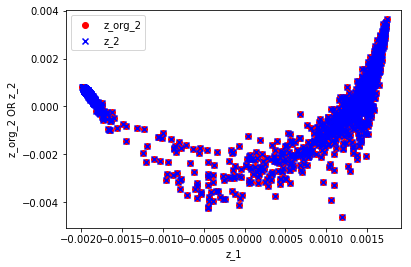

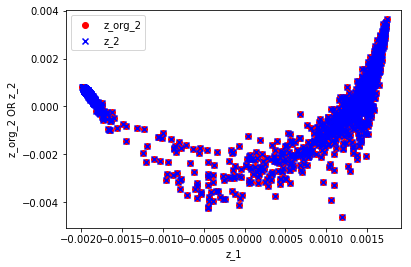

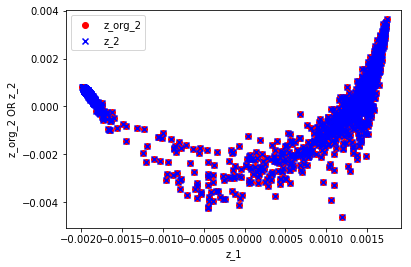

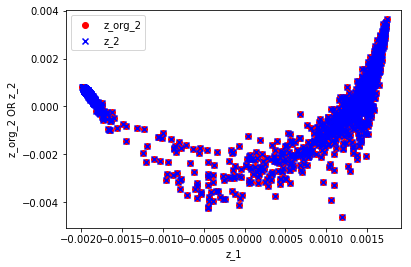

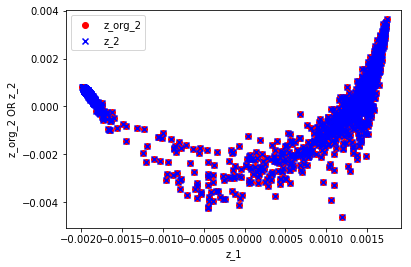

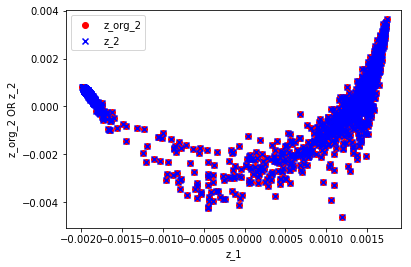

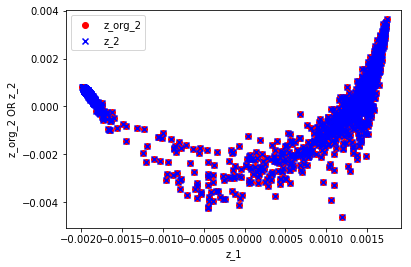

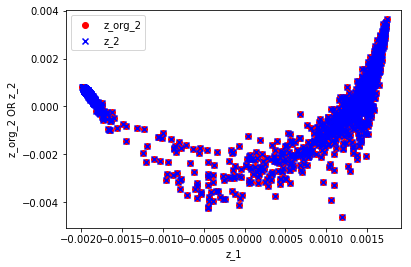

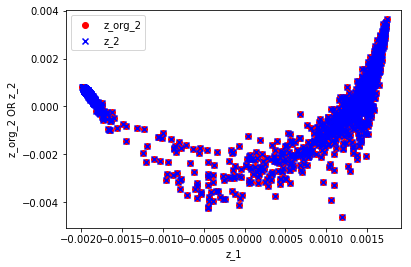

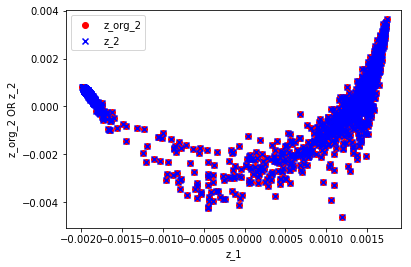

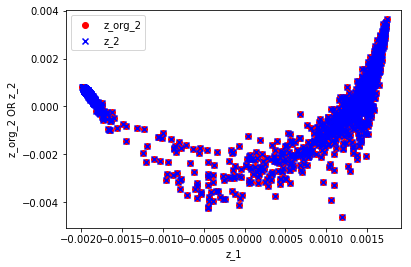

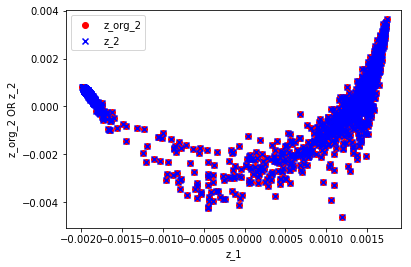

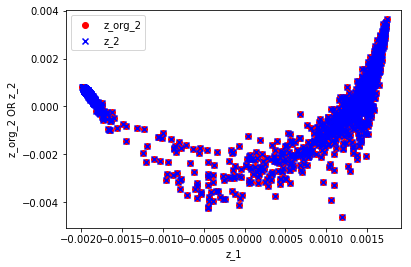

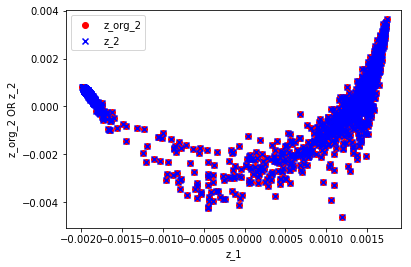

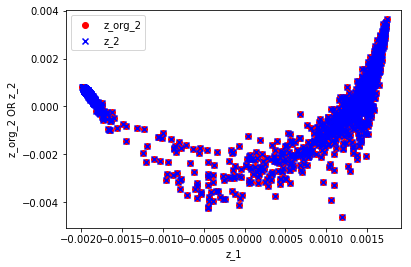

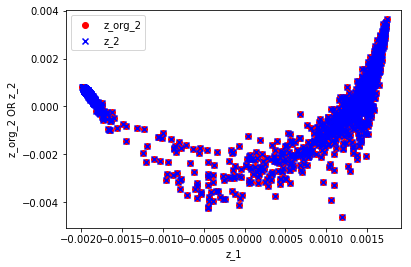

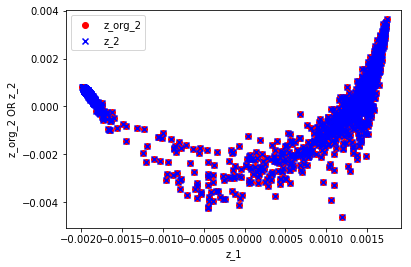

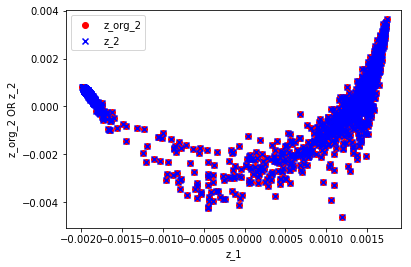

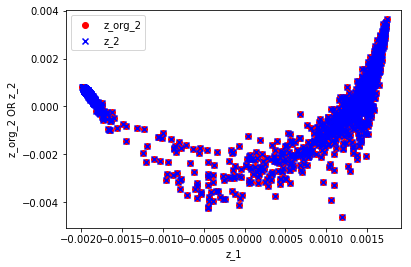

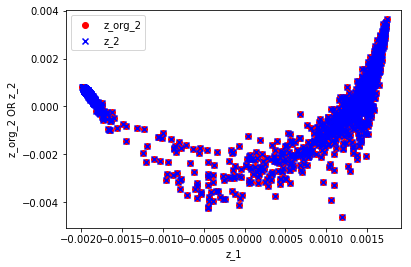

In [36]:
plot_stride = 100
bin_sizes = [1]
Dvec = [40000] 

#bin_sizes = [1]
#Dvec = [40000] 
for Dv in Dvec:
    for b in bin_sizes:
        z_org = np.load('data_%dk_%fns.npz' %(Dv,b*0.2))
        z_org = npzfile['z']

bin_sizes = [1,5,10,25,50]
Dvec = [40000,20000,10000,1000] 
for Dv in Dvec:
    for b in bin_sizes:
        z = np.load('data_%dk_%fns.npz' %(Dv,b*0.2))
        z = npzfile['z']
        #for i in range(z.shape[1]):
         #   for j in range(z_org.shape[1]):
        #for i in range(1,3):
         #   for j in range(1,3):
        plot_reconstr_2(1,2,plot_stride)
                

In [32]:
z.shape[1]

20

In [ ]:
def plot_reconstr(i,plot_stride):
    
    '''
    i - index of z_aa for which to plot reconstruction
    plot_stride - frame skipper
    '''
    
    # 3D plots
    x_idx=0
    y_idx=1
    
    xmin = np.min(z[::plot_stride,x_idx])
    xmax = np.max(z[::plot_stride,x_idx])
    ymin = np.min(z[::plot_stride,y_idx])
    ymax = np.max(z[::plot_stride,y_idx])
    zmin = np.min( [ np.min(z_org[::plot_stride,i]), np.min(z[::plot_stride,i]) ] )
    zmax = np.max( [ np.max(z_org[::plot_stride,i]), np.max(z[::plot_stride,i]) ] )
    
    #- z_aa
    ax = plt.subplot(111, projection='3d')
    ax.scatter(z[::plot_stride,x_idx], z[::plot_stride,y_idx], z_org[::plot_stride,i], c='r', marker='o')
       
    plt.xlim(xmin*1.1,xmax*1.1)
    plt.ylim(ymin*1.1,ymax*1.1)
    ax.set_zlim(zmin*1.1,zmax*1.1)
    
    ax.set_xlabel('z_' + str(x_idx))
    ax.set_ylabel('z_' + str(y_idx))
    ax.set_zlabel('z_org_' + str(i) + ' OR z_' + str(i))
    
    ax.legend(['z_org_' + str(i), 'z_' + str(i)])
    
    fig = plt.gcf()
    fig.savefig('z_org_' + str(i) + '.png', dpi=300)
    if showPlots:
        plt.draw()
        plt.show()
    plt.close()
        
    #- z_aa_pred
    ax = plt.subplot(111, projection='3d')
    ax.scatter(z_Takens[::plot_stride,x_idx], z_Takens[::plot_stride,y_idx], z_aa_pred[::plot_stride,i], c='b', marker='x')
       
    plt.xlim(xmin*1.1,xmax*1.1)
    plt.ylim(ymin*1.1,ymax*1.1)
    ax.set_zlim(zmin*1.1,zmax*1.1)
    
    ax.set_xlabel('z_' + str(x_idx))
    ax.set_ylabel('z_' + str(y_idx))
    ax.set_zlabel('z_org_' + str(i) + ' OR z_' + str(i))
    
    ax.legend(['z_org_' + str(i), 'z_' + str(i)])
    
    fig = plt.gcf()
    fig.savefig('z_' + str(i) + '.png', dpi=300)
    if showPlots:
        plt.draw()
        plt.show()
    plt.close()
    
    #- z_aa & z_aa_pred
    ax = plt.subplot(111, projection='3d')
    ax.scatter(z_Takens[::plot_stride,x_idx], z_Takens[::plot_stride,y_idx], z_aa[::plot_stride,i], c='r', marker='o')
    ax.scatter(z_Takens[::plot_stride,x_idx], z_Takens[::plot_stride,y_idx], z_aa_pred[::plot_stride,i], c='b', marker='x')
       
    plt.xlim(xmin*1.1,xmax*1.1)
    plt.ylim(ymin*1.1,ymax*1.1)
    ax.set_zlim(zmin*1.1,zmax*1.1)
    
    ax.set_xlabel('z_' + str(x_idx))
    ax.set_ylabel('z_' + str(y_idx))
    ax.set_zlabel('z_org_' + str(i) + ' OR z_' + str(i))
    
    ax.legend(['z_org_' + str(i), 'z_' + str(i)])
    
    fig = plt.gcf()
    fig.savefig('z_org_AND_z_' + str(i) + '.png', dpi=300)
    if showPlots:
        plt.draw()
        plt.show()
    plt.close()
    


plot_stride = 100
plot_reconstr(0,plot_stride)
plot_reconstr(1,plot_stride)

def plot_reconstr_2(i,j,plot_stride):
    
    '''
    i - index of z_Takens to use for x-axis
    j - index of z_aa and z_aa_pred to use for y-axis
    plot_stride - frame skipper
    '''
    
    ax = plt.subplot(111)
    ax.scatter(z_Takens[::plot_stride,i], z_aa[::plot_stride,j], c='r', marker='o')
    ax.scatter(z_Takens[::plot_stride,i], z_aa_pred[::plot_stride,j], c='b', marker='x')
    
    xmin = np.min( z_Takens[::plot_stride,i] )
    xmax = np.max( z_Takens[::plot_stride,i] )
    ymin = np.min( [ np.min(z_aa[::plot_stride,j]), np.min(z_aa_pred[::plot_stride,j]) ] )
    ymax = np.max( [ np.max(z_aa[::plot_stride,j]), np.max(z_aa_pred[::plot_stride,j]) ] )
    
    plt.xlim(xmin*1.1,xmax*1.1)
    plt.ylim(ymin*1.1,ymax*1.1)

    ax.set_xlabel('z_Takens_' + str(i))
    ax.set_ylabel('z_aa_' + str(j) + ' OR z_aa_pred_' + str(j))
    
    ax.legend(['z_aa_' + str(j), 'z_aa_pred_' + str(j)])
    
    fig = plt.gcf()
    fig.savefig('z_Takens_' + str(i) + '_VS_z_aa_' + str(j) + '.png', dpi=300)
    if showPlots:
        plt.draw()
        plt.show()
    plt.close()

plot_stride = 100
for i in range(z_Takens.shape[1]):
    for j in range(z_aa.shape[1]):
        plot_reconstr_2(i,j,plot_stride)